In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import pickle

from emgdecompy.preprocessing import * 
from functions import *
from realtime_decomp import *

# Gastrocnemius lateralis
gl_10 = loadmat('./data/experimental_data_raw/gl_10.mat')['SIG']

indpt_gl10_pnr = loadmat('./data/experimental_data_raw/gl_10.mat')['MUPulses']
ref_gl10_pnr = loadmat('./data/experimental_data_raw/gl_10.mat')['ref_signal']


with open('./data/decomp_gl_10.obj', 'rb') as f: decomp_gl10 = pickle.load(f)
with open('./data/decomp_gl10_tmod.obj', 'rb') as f: decomp_gl10_tmod = pickle.load(f)
with open('./data/decomp_gl10_x5_tmod.obj', 'rb') as f: decomp_gl10_x5_tmod = pickle.load(f)
with open('./data/decomp_gl10_x5x36_tmod.obj', 'rb') as f: decomp_gl10_x5x36_tmod = pickle.load(f)

In [2]:
data = gl_10
signal = "gl_10"
ref_signal = ref_gl10_pnr
batch_size = 4.0
noise_start = 0.0
noise_end = 3.0
ol=[1.0, 2.0, 3.0]

bad_ch = bad_channels(data, signal=signal, thd_snr=2.0, noise_start=0.0, noise_end=3.0, fs=2048)
snr = calc_snr(data, 
               noise_start=noise_start, noise_end=noise_end, fs=2048)

disc_ch = loadmat('./data/experimental_data_raw/gl_10.mat')['discardChannelsVec']
disc_ch_flat = discard_ch_flat(disc_ch, data)


print(disc_ch_flat)
disc_ch_bad = np.argwhere(disc_ch_flat == 1)
print(disc_ch_bad)
print(snr[disc_ch_bad])


Bad channels in gl_10: [ 5 36]
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[[5]]
[[0.49740866]]


# a. Training Module
## i. Decomposition

In [3]:
decomp = decomp_gl10_x5x36_tmod

In [ ]:
decomp = decomposition_tmod(x=data,
                            discard=bad_ch,
                            R=16,
                            M=64,
                            bandpass=True,
                            lowcut=10,
                            highcut = 900,
                            fs=2048,
                            order=6,
                            Tolx=10e-4,
                            contrast_fun=skew,
                            ortho_fun=gram_schmidt,
                            max_iter_sep=10,
                            l=31,
                            sil_pnr=True,
                            thresh=0.9,
                            max_iter_ref=10,
                            random_seed=None,
                            verbose=False)

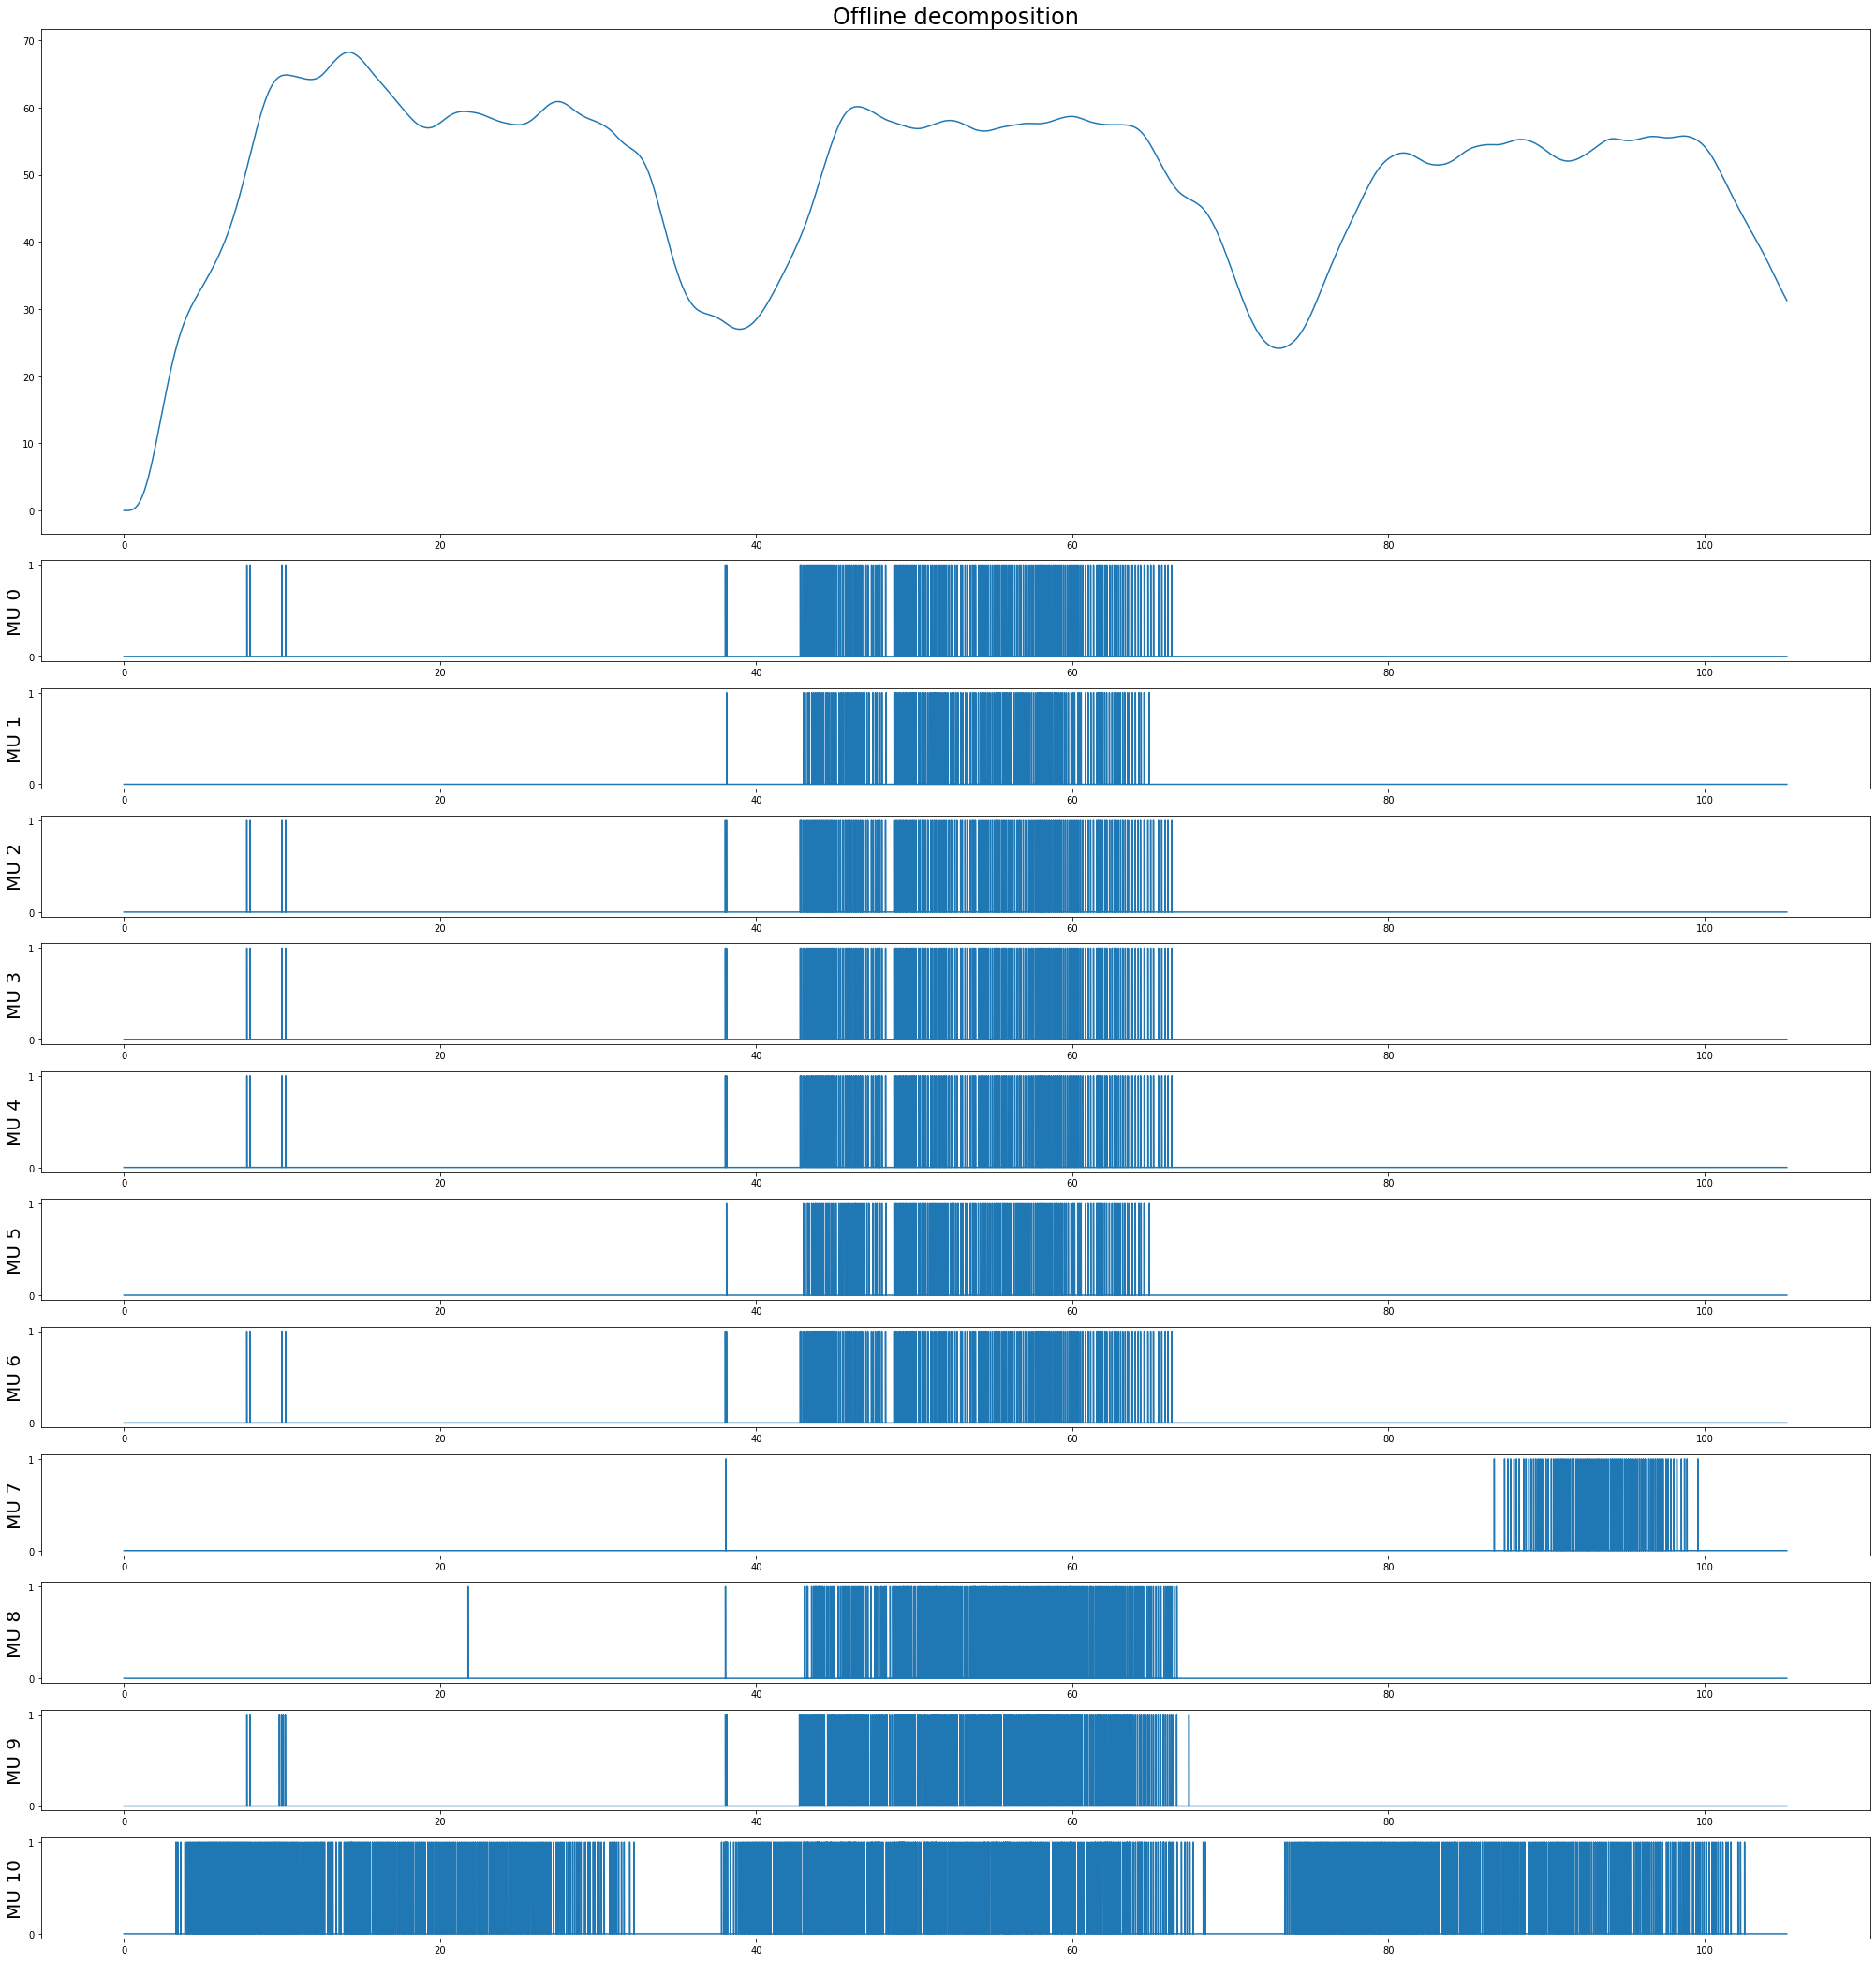

In [4]:
visualize_pt(decomp["MUPulses"], 
             data, title="Offline decomposition")

## ii. Separation matrix

In [4]:
# Realtime separation matrix
B = decomp["B"]
B_rt, mean_tm = sep_realtime(data, B, discard=bad_ch)

# Signal and noise centroids
signal_centroids_tm = decomp["peak_centroids"]
noise_centroids_tm = decomp["noise_centroids"]

# s^2 from the offline decomposition
s2_tm = np.square(decomp["s"])

# normalized signal and noise centroids (centroid / max(s^2))
sc_tm = []
nc_tm = []
for i in range(signal_centroids_tm.size):
    sc_tm.append(signal_centroids_tm[i] / signal_centroids_tm.max())
    nc_tm.append(noise_centroids_tm[i] / signal_centroids_tm.max())
sc_tm = np.array(sc_tm)
nc_tm = np.array(nc_tm)

# b. Decomposition module
## i. `kmeans_sil_cp`
### 4.0s, no overlap

In [5]:
kmeans_sil_cp_40 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=0.0)

In [6]:
roa_kmeans_sil_cp_40 = calc_roa(ind_pt1=kmeans_sil_cp_40["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_sil_cp {batch_size}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s (%):
Motor unit 0: 25.0
Motor unit 1: 2.5726141078838176
Motor unit 2: 8.938053097345133
Motor unit 3: 40.74074074074074
Motor unit 4: 52.96610169491525
Motor unit 5: 5.091258405379443
Motor unit 6: 10.592808551992226
Motor unit 7: 4.853128991060026
Motor unit 8: 6.408345752608048
Motor unit 9: 9.84251968503937
Motor unit 10: 2.3961661341853033
mean: 15.400157923740853


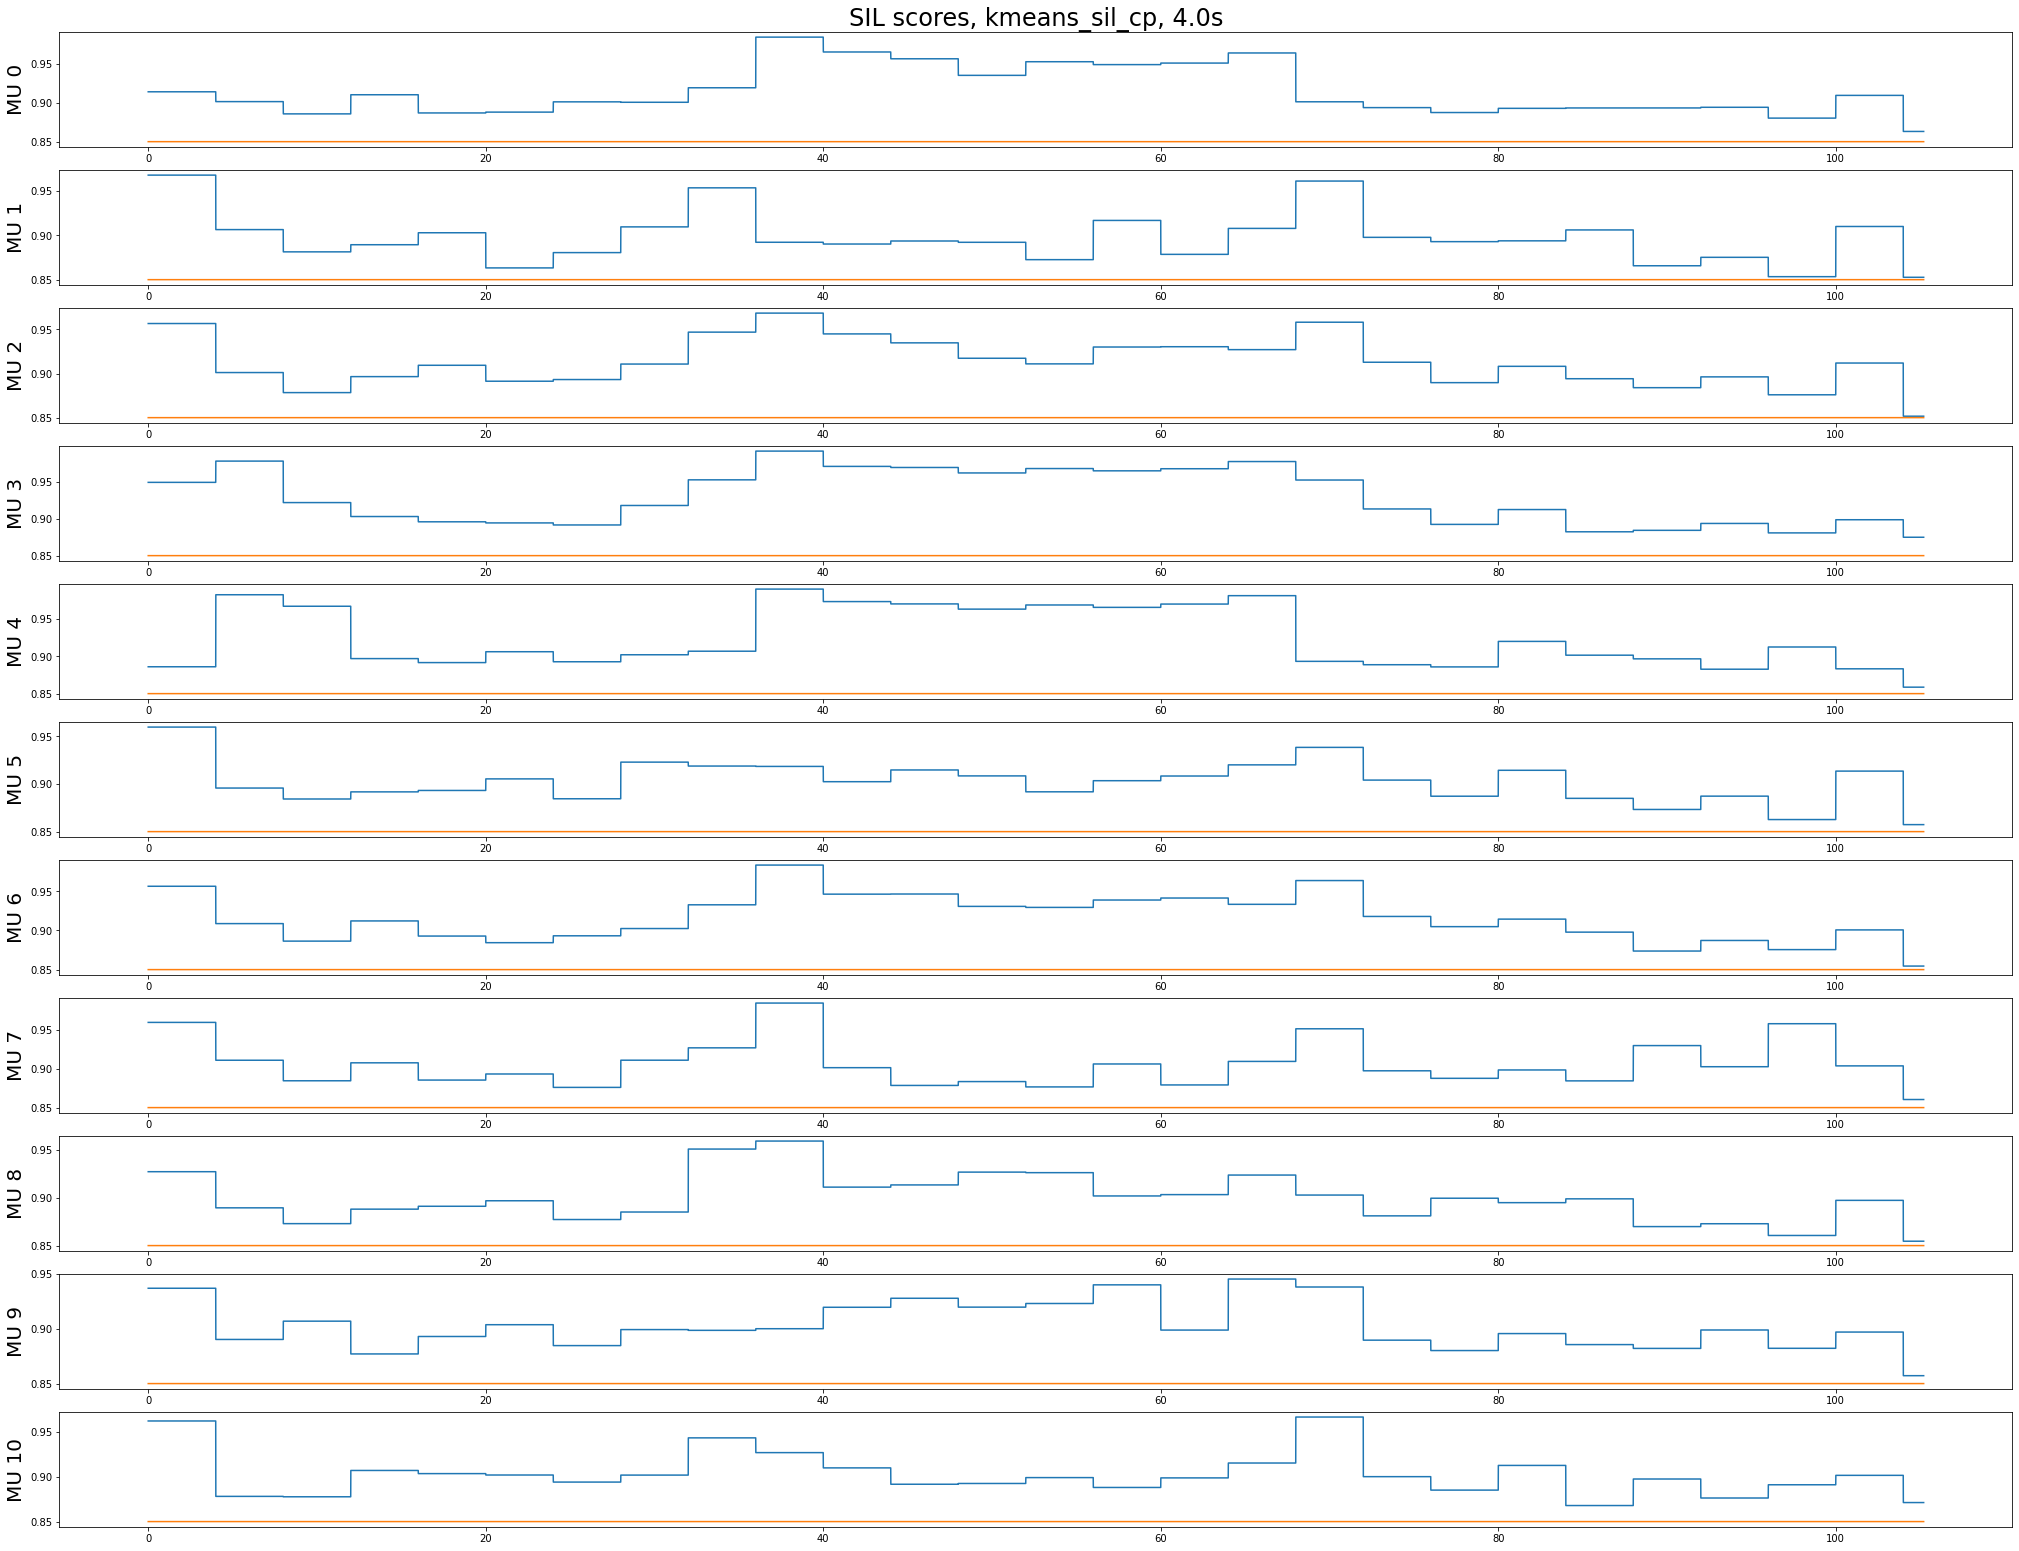

In [7]:
plot_sil(kmeans_sil_cp_40["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s")

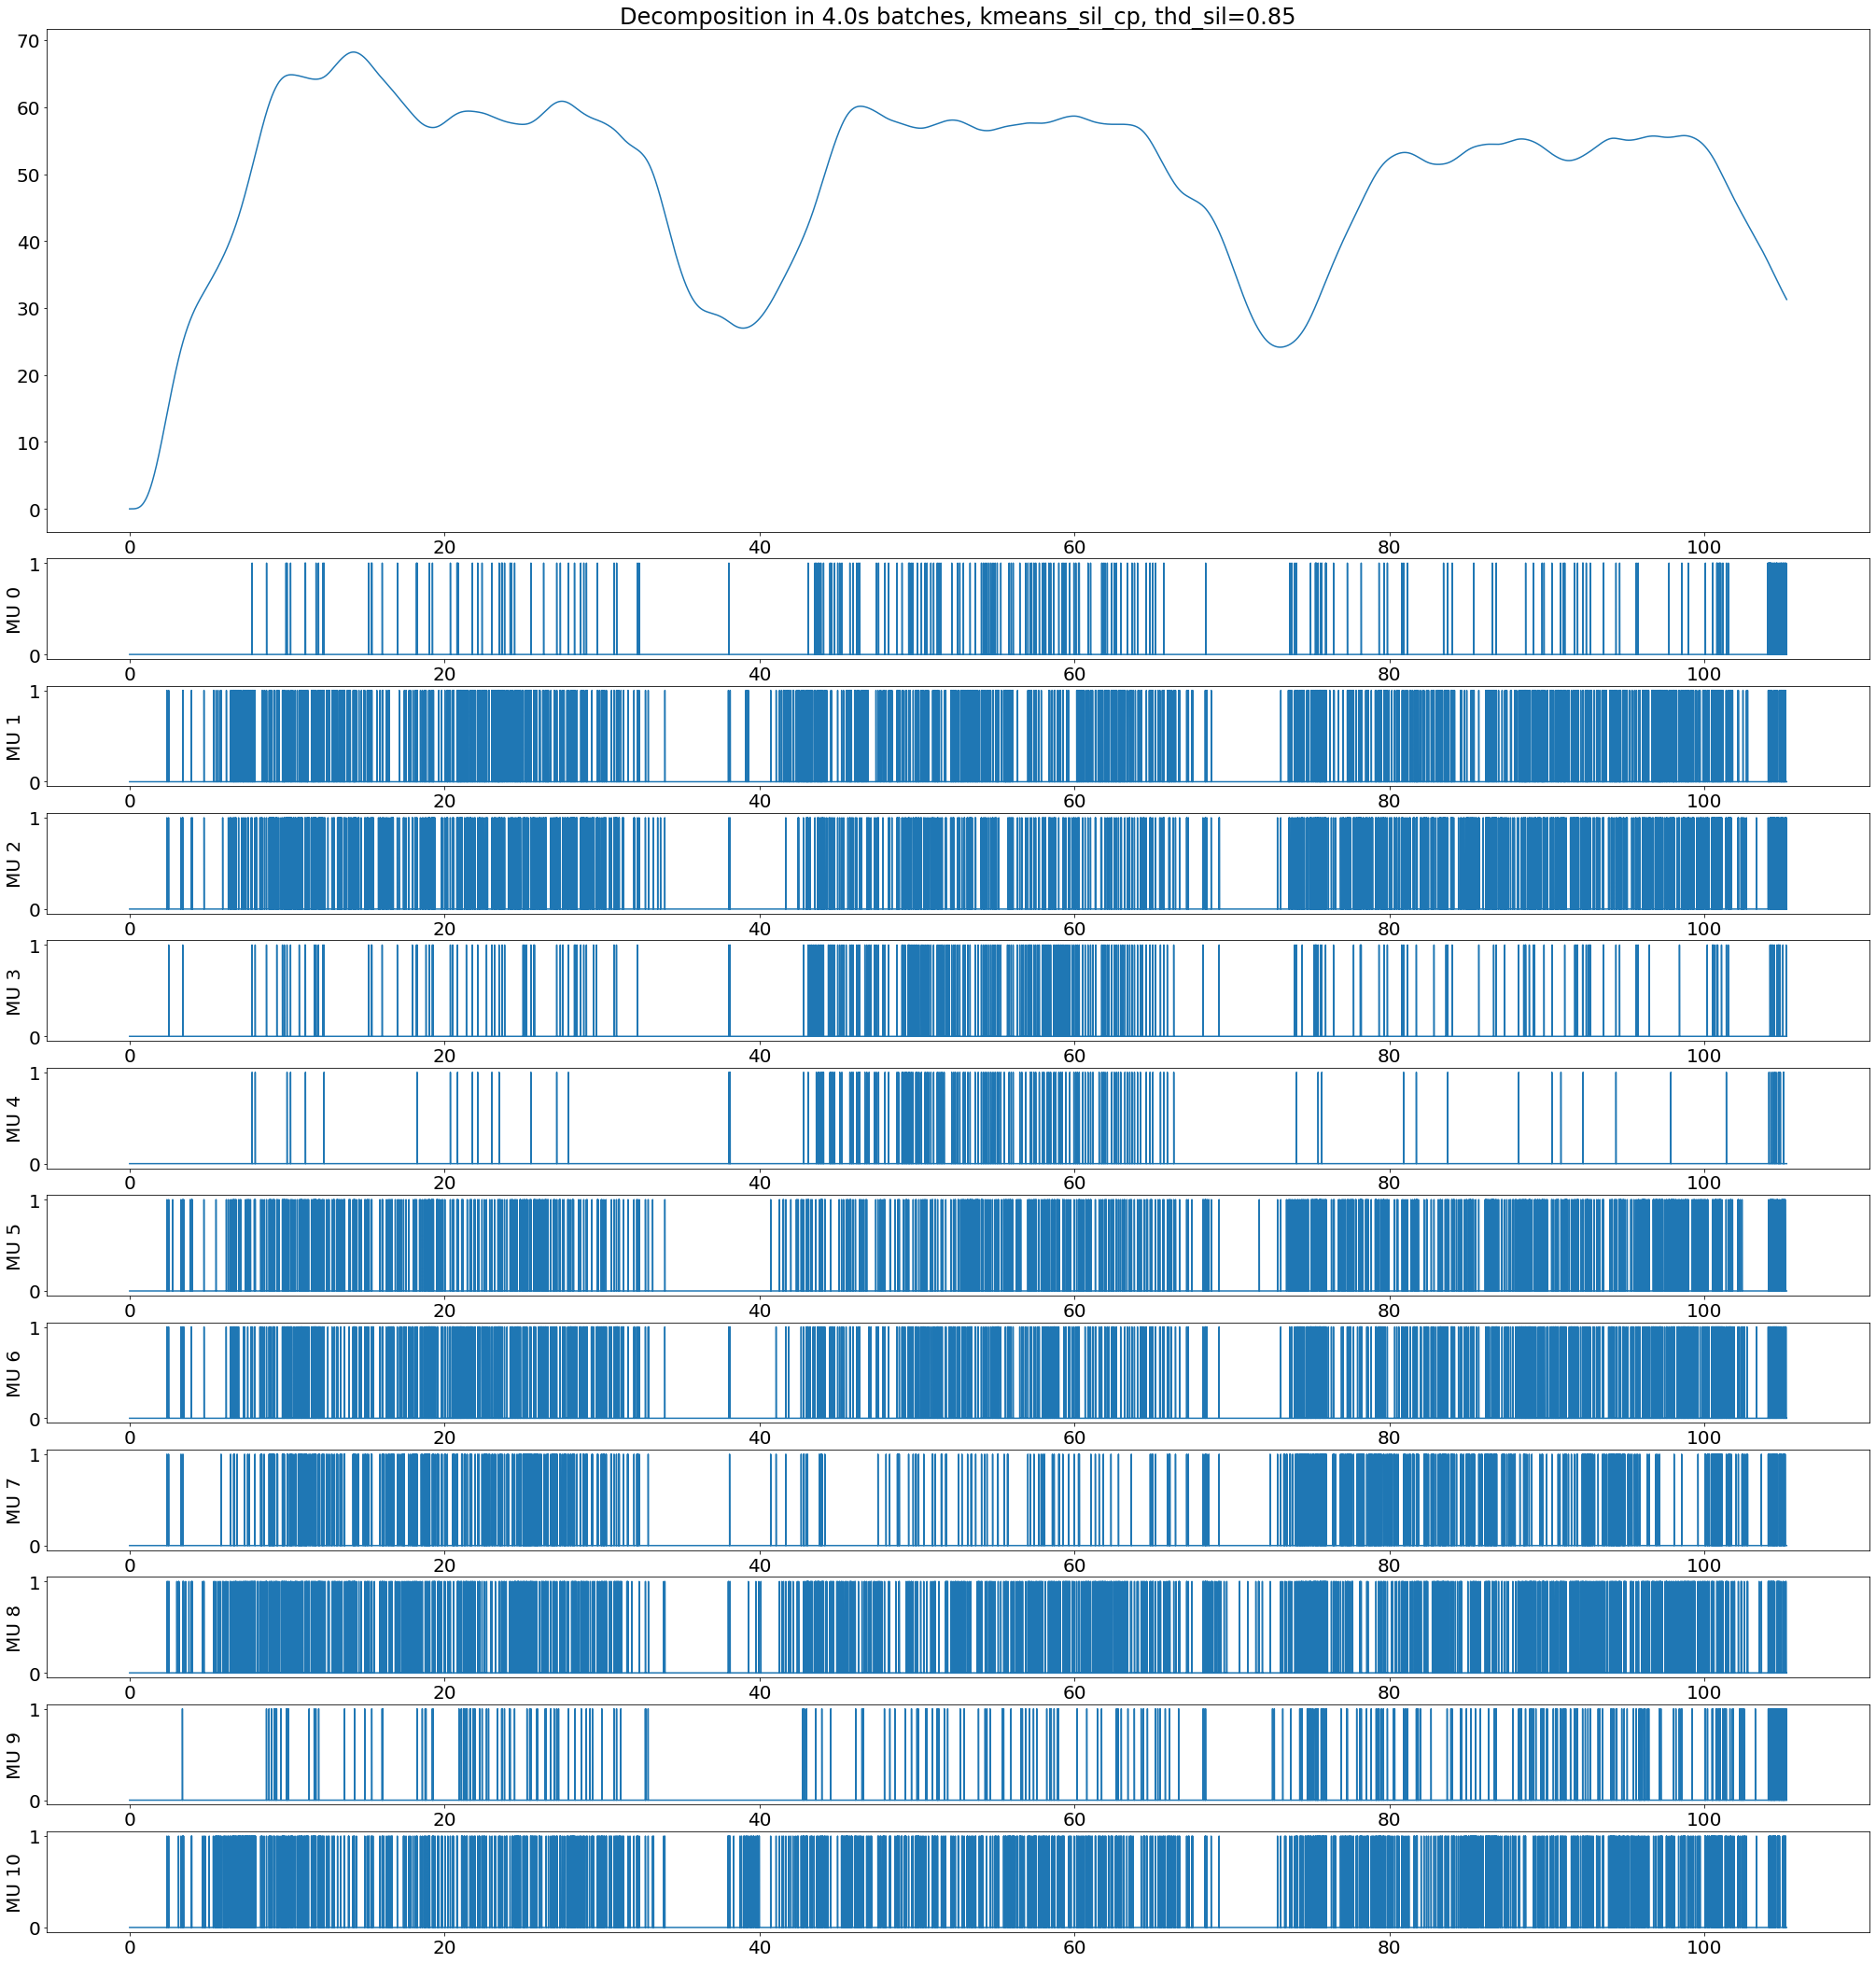

In [8]:
visualize_pt(kmeans_sil_cp_40["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, kmeans_sil_cp, thd_sil=0.85")

### 4.0s, 1.0s overlap

In [9]:
kmeans_sil_cp_40_ol10 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[0])

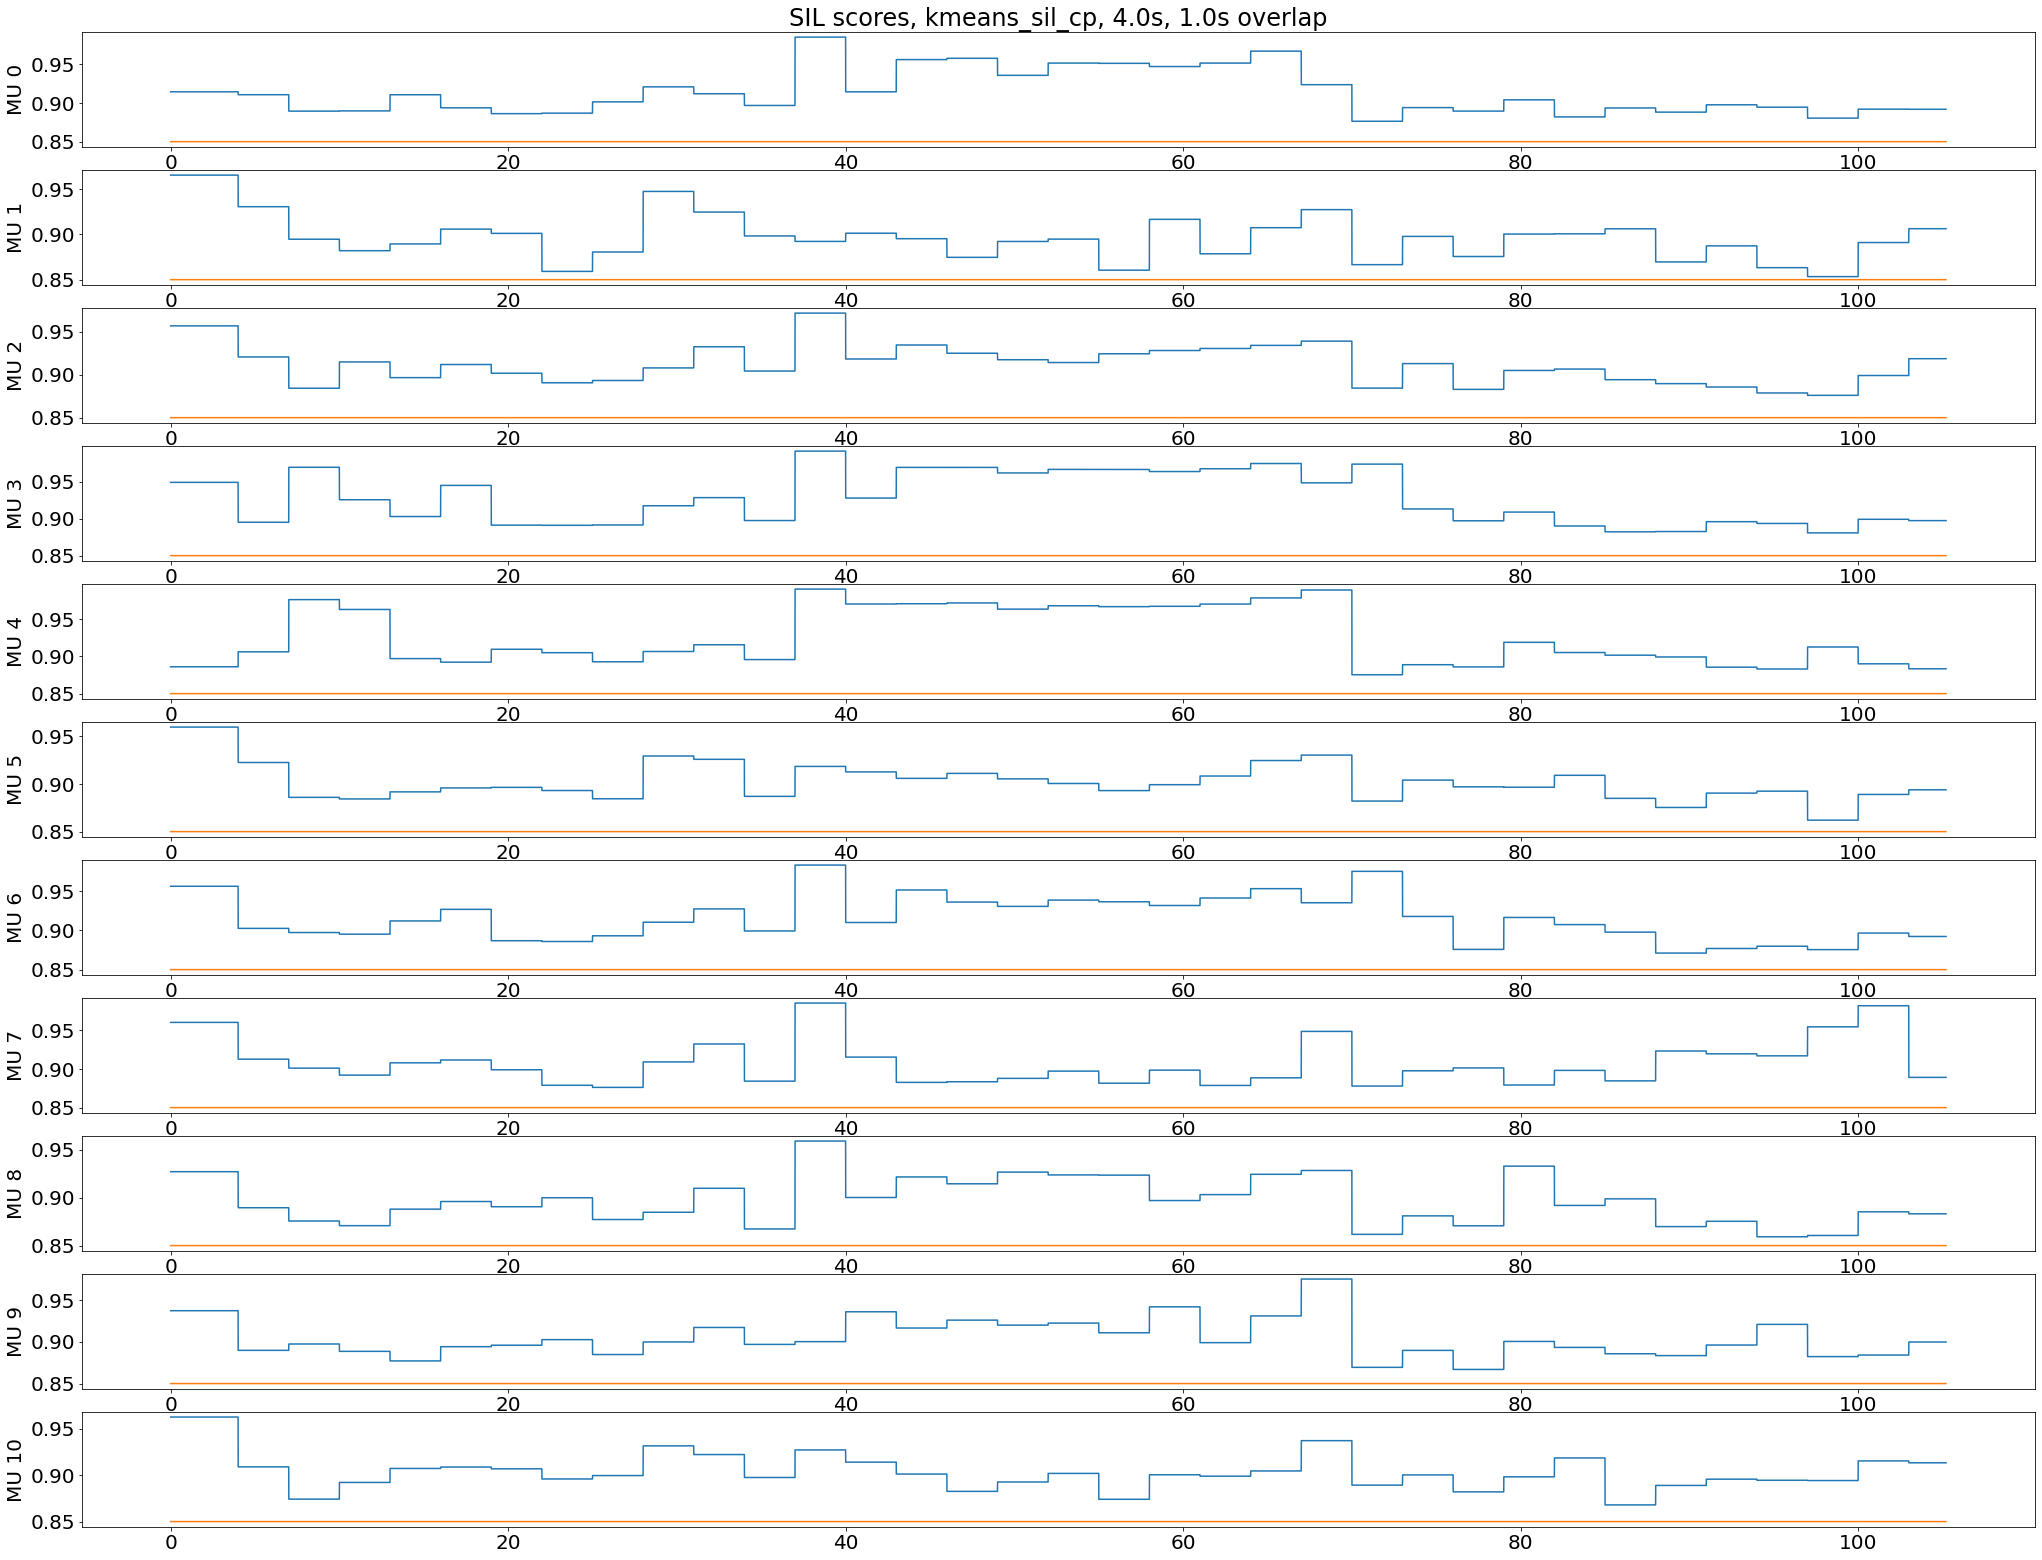

In [10]:
plot_sil(kmeans_sil_cp_40_ol10["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s, {ol[0]}s overlap")

In [11]:
roa_kmeans_sil_cp_40_ol10 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol10["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_sil_cp {batch_size}s, overlap:{ol[0]}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s, overlap:1.0s (%):
Motor unit 0: 26.993865030674847
Motor unit 1: 2.7966101694915255
Motor unit 2: 8.956602031394276
Motor unit 3: 41.54302670623145
Motor unit 4: 53.81165919282511
Motor unit 5: 5.08637236084453
Motor unit 6: 11.066799601196411
Motor unit 7: 5.49597855227882
Motor unit 8: 5.602836879432624
Motor unit 9: 10.309278350515465
Motor unit 10: 2.185792349726776
mean: 15.80443829314653


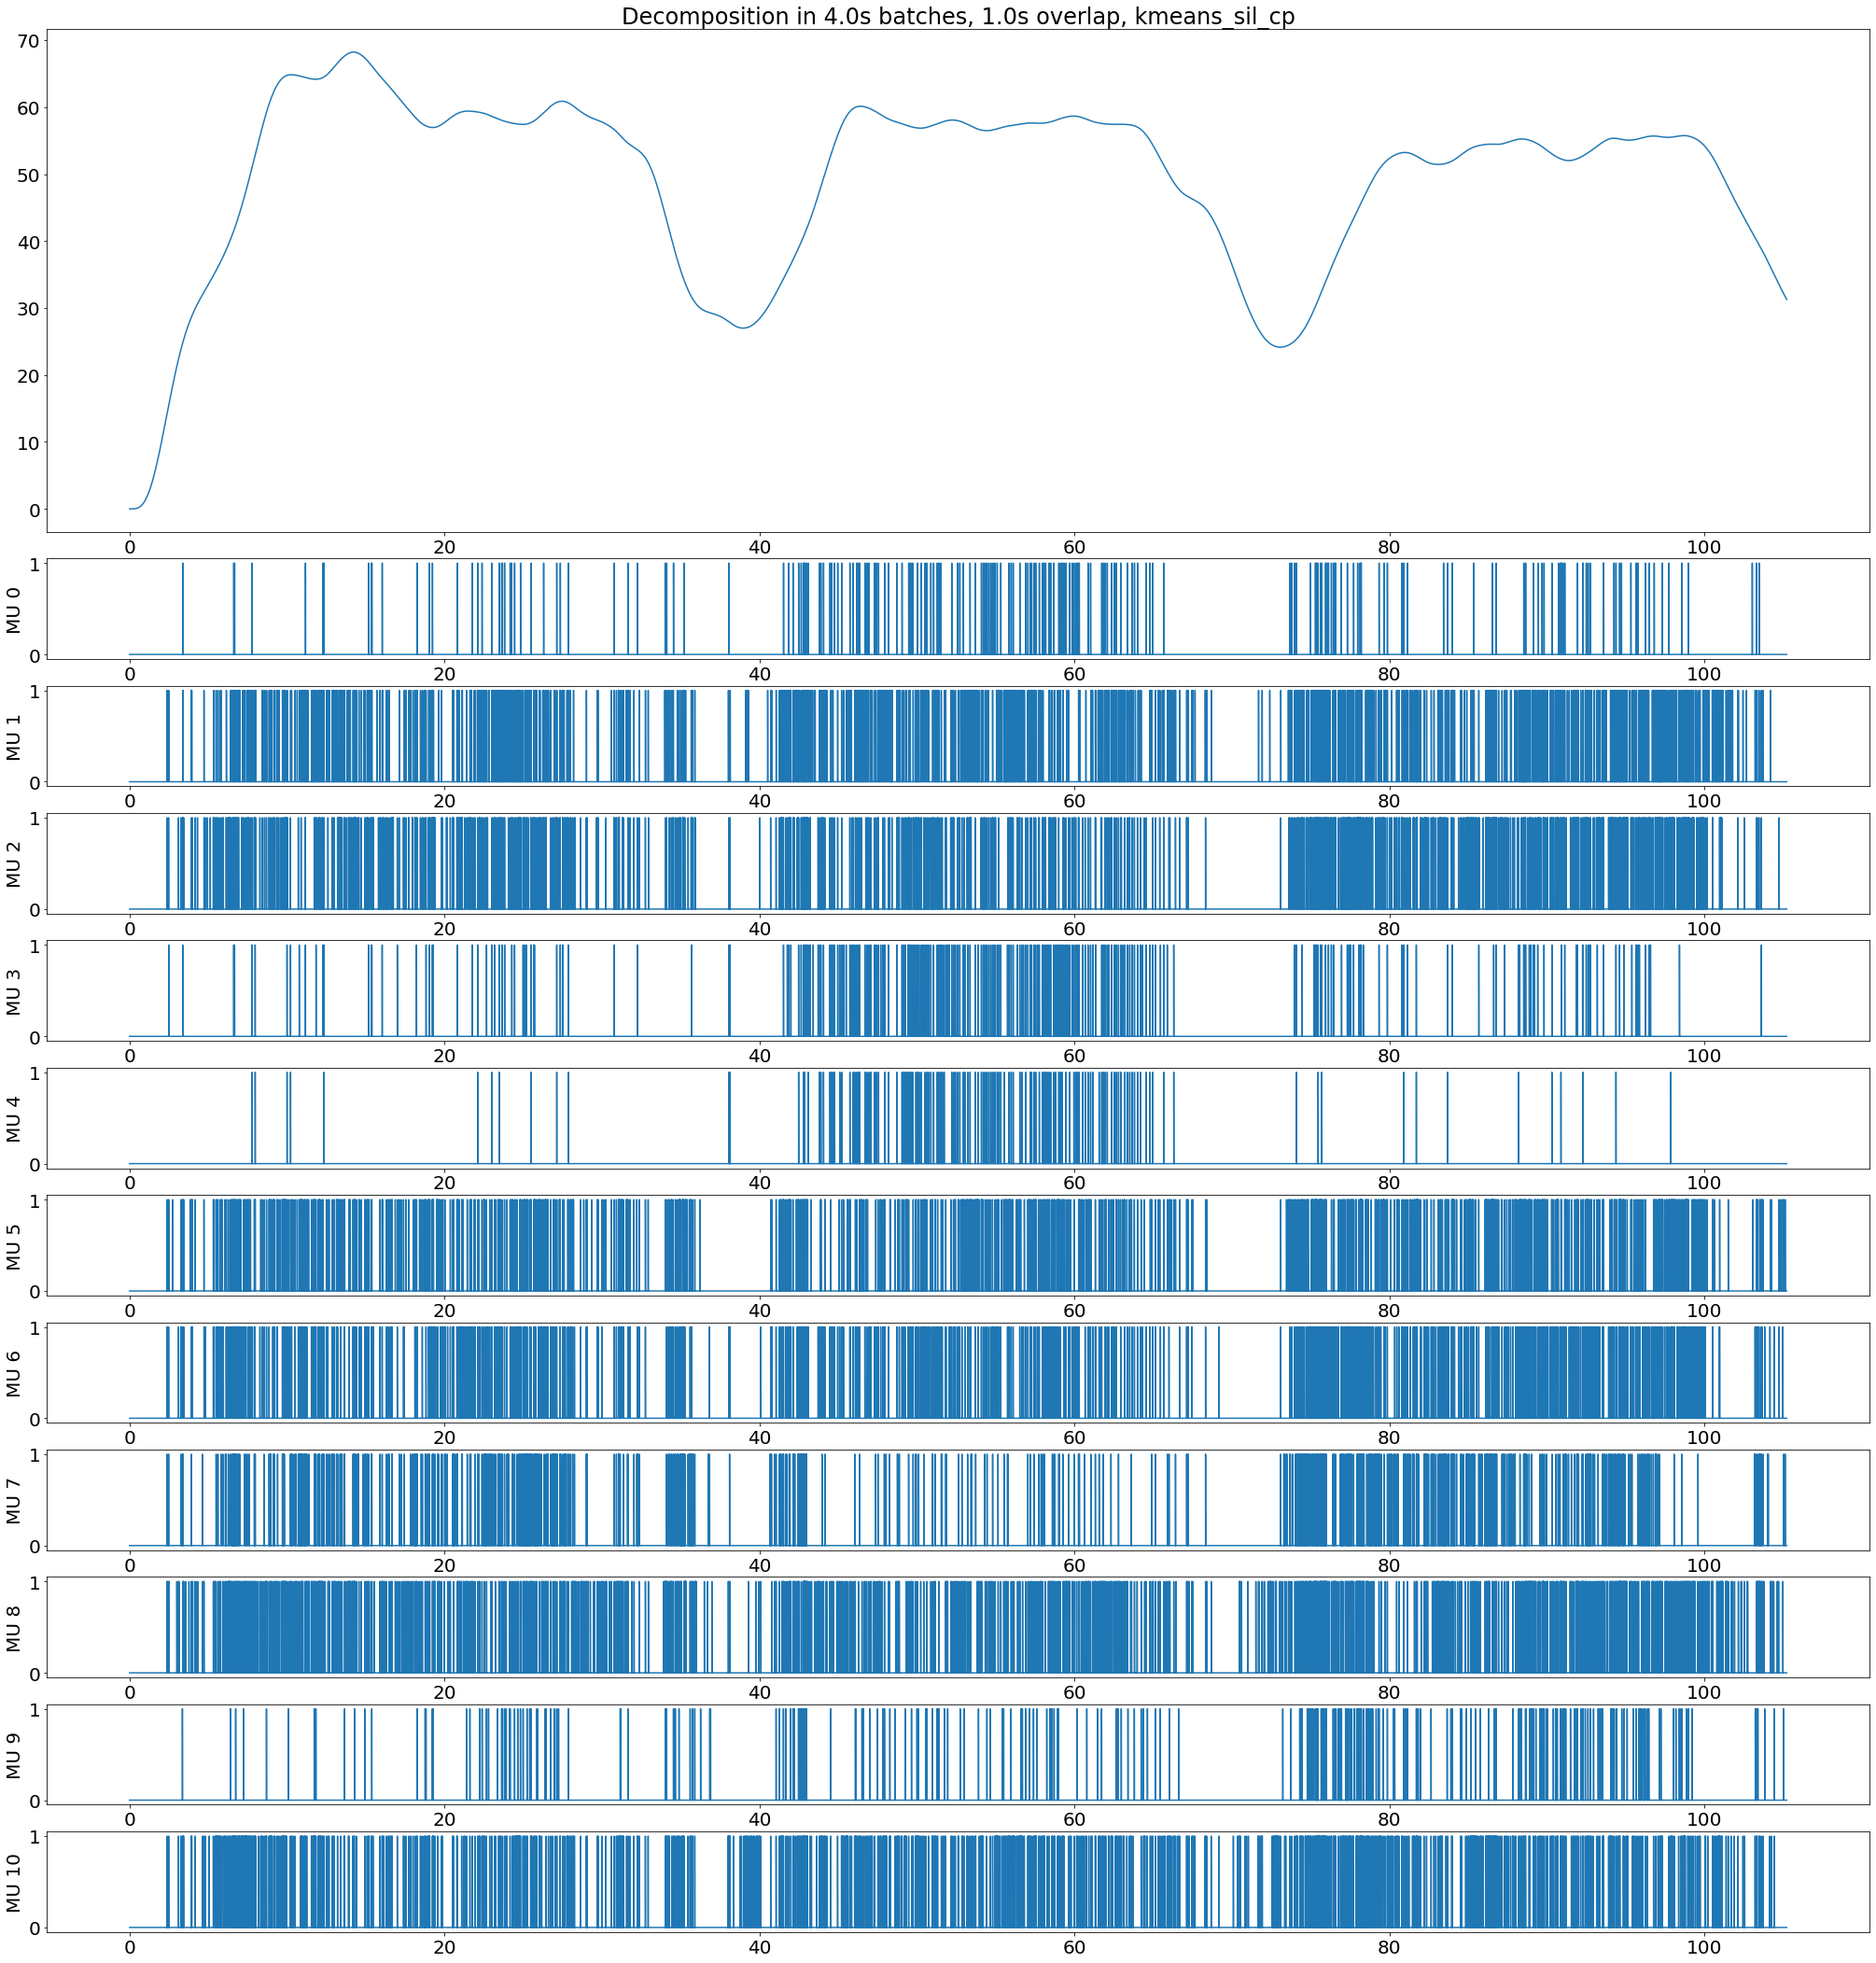

In [12]:
visualize_pt(kmeans_sil_cp_40_ol10["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[0]}s overlap, kmeans_sil_cp")

### 4.0s, 2.0s overlap

In [13]:
kmeans_sil_cp_40_ol20 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[1])

In [14]:
roa_kmeans_sil_cp_40_ol20 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol20["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_sil_cp {batch_size}s, overlap:{ol[1]}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s, overlap:2.0s (%):
Motor unit 0: 25.294117647058822
Motor unit 1: 2.6586620926243567
Motor unit 2: 9.057971014492754
Motor unit 3: 40.11461318051576
Motor unit 4: 53.275109170305676
Motor unit 5: 5.257936507936508
Motor unit 6: 10.650887573964496
Motor unit 7: 5.732484076433121
Motor unit 8: 6.188679245283019
Motor unit 9: 9.161793372319687
Motor unit 10: 2.217414818820984
mean: 15.419060790886833


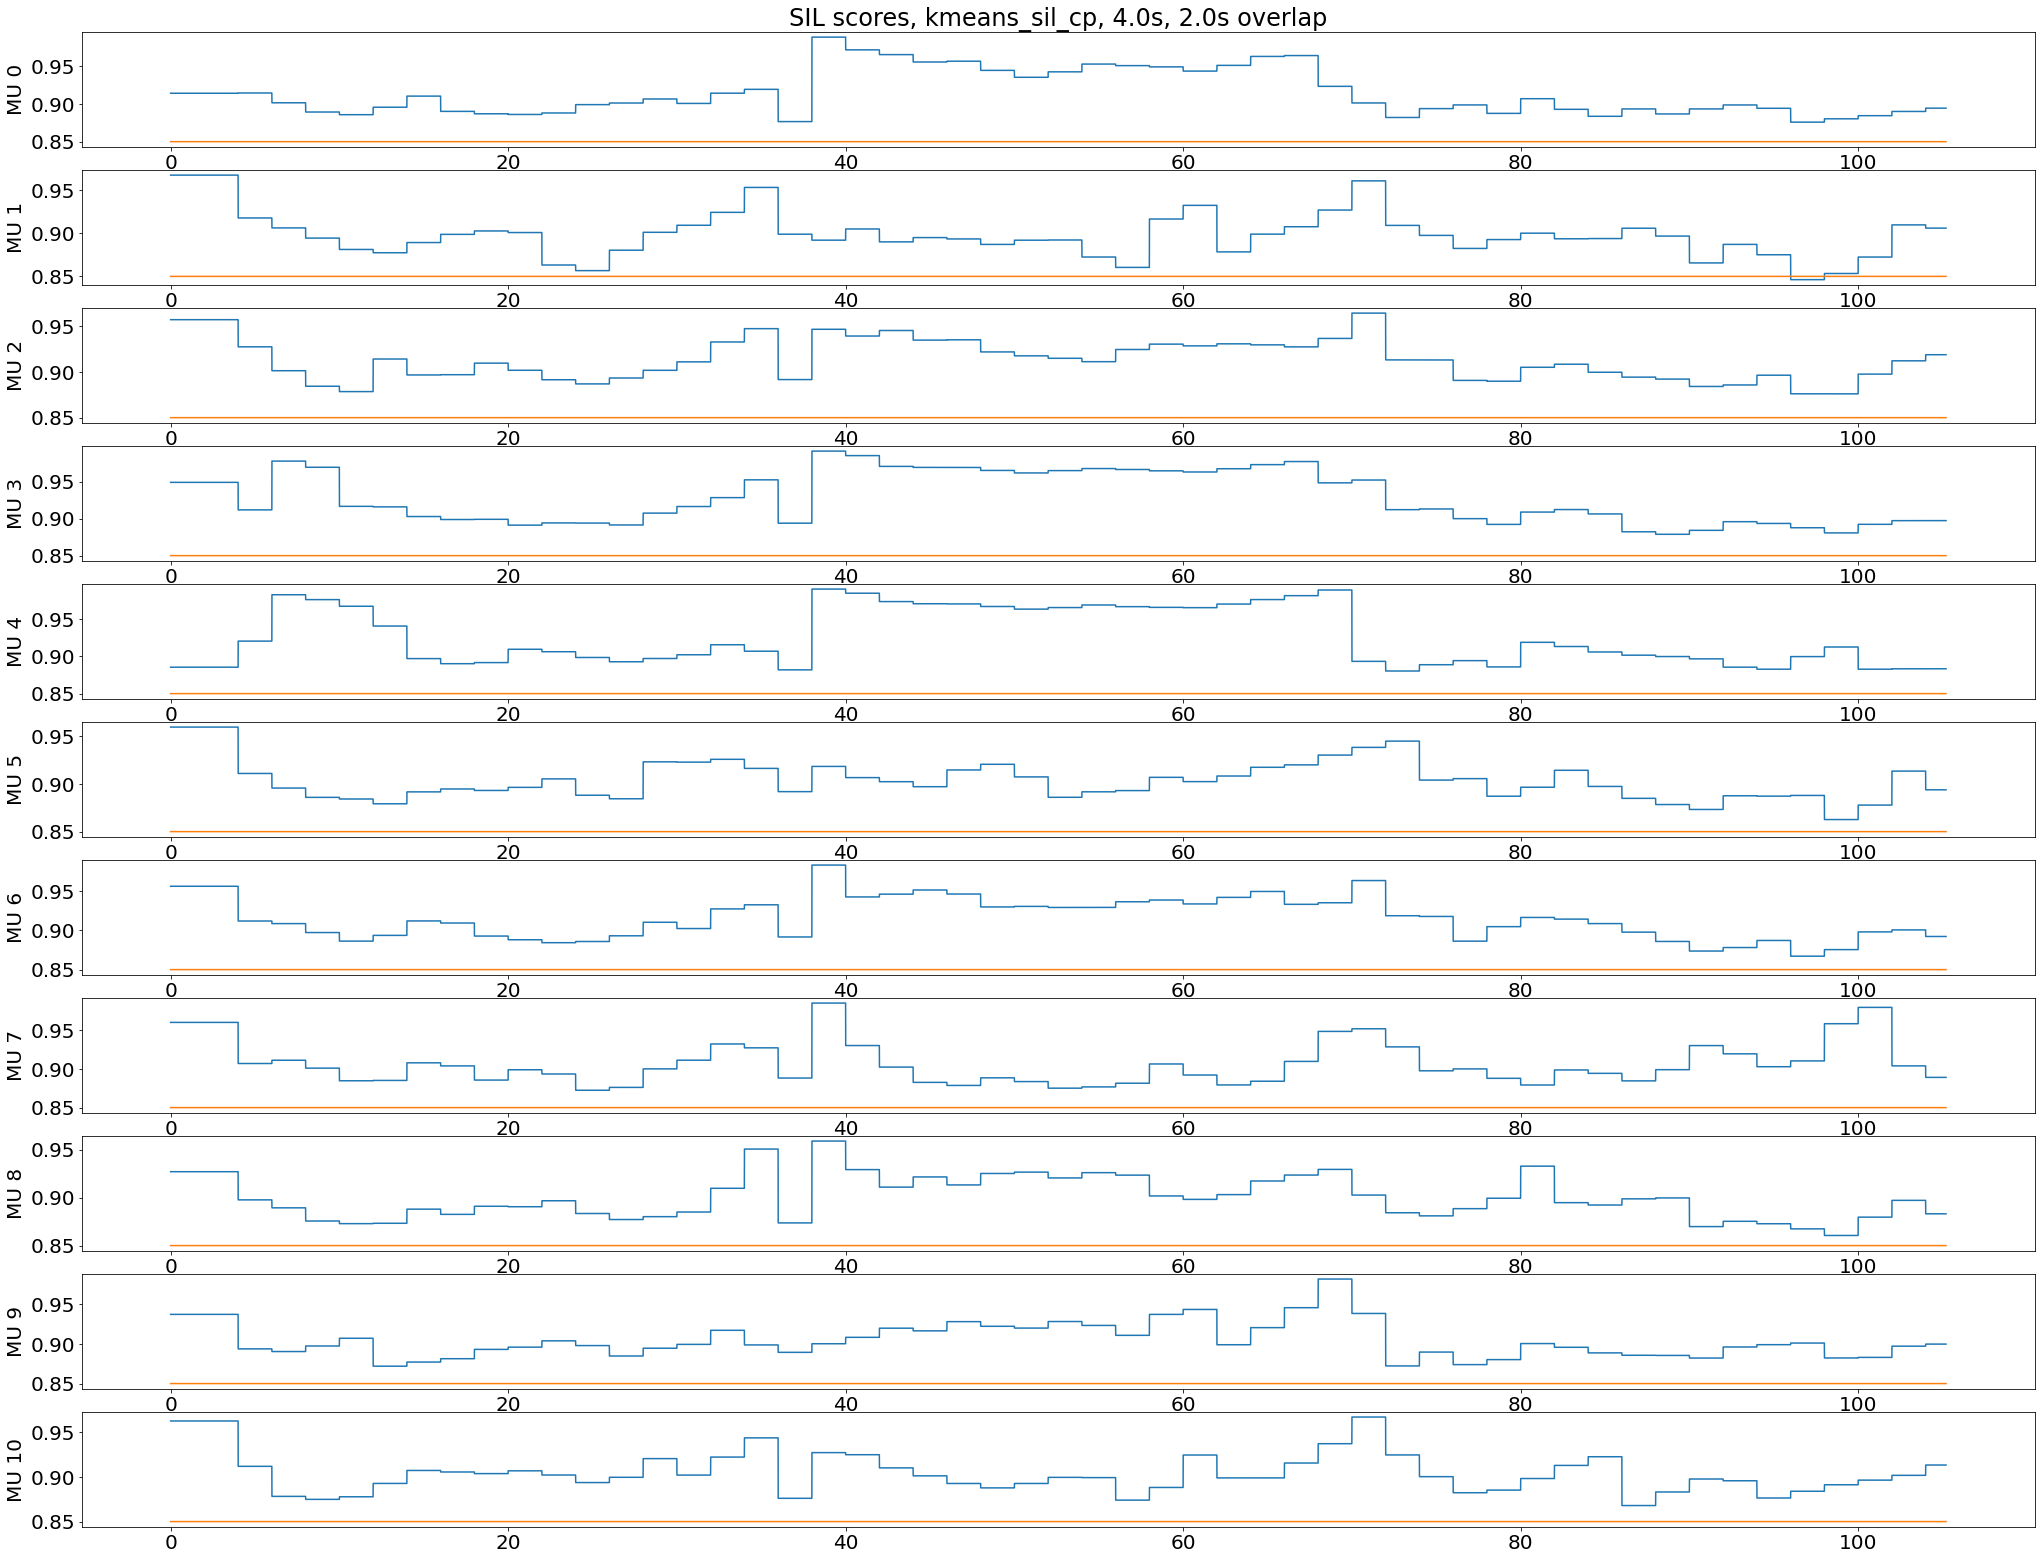

In [15]:
plot_sil(kmeans_sil_cp_40_ol20["sil_scores"], thd_sil=0.85, 
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s, {ol[1]}s overlap")

In [16]:
visualize_pt(kmeans_sil_cp_40_ol20["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[1]}s overlap, kmeans_sil_cp")

### 4.0s, 3.0s overlap

In [17]:
kmeans_sil_cp_40_ol30 = batch_decomp(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.85, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[2])

In [18]:
roa_kmeans_sil_cp_40_ol30 = calc_roa(ind_pt1=kmeans_sil_cp_40_ol30["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_sil_cp {batch_size}s, overlap:{ol[2]}s")

RoA between offline decomposition and kmeans_sil_cp 4.0s, overlap:3.0s (%):
Motor unit 0: 24.576271186440678
Motor unit 1: 2.7705627705627704
Motor unit 2: 8.579088471849866
Motor unit 3: 38.41961852861036
Motor unit 4: 52.36051502145923
Motor unit 5: 5.303760848601736
Motor unit 6: 10.7421875
Motor unit 7: 5.602923264311815
Motor unit 8: 5.964653902798233
Motor unit 9: 8.834586466165414
Motor unit 10: 2.2411953041622197
mean: 15.035942114996573


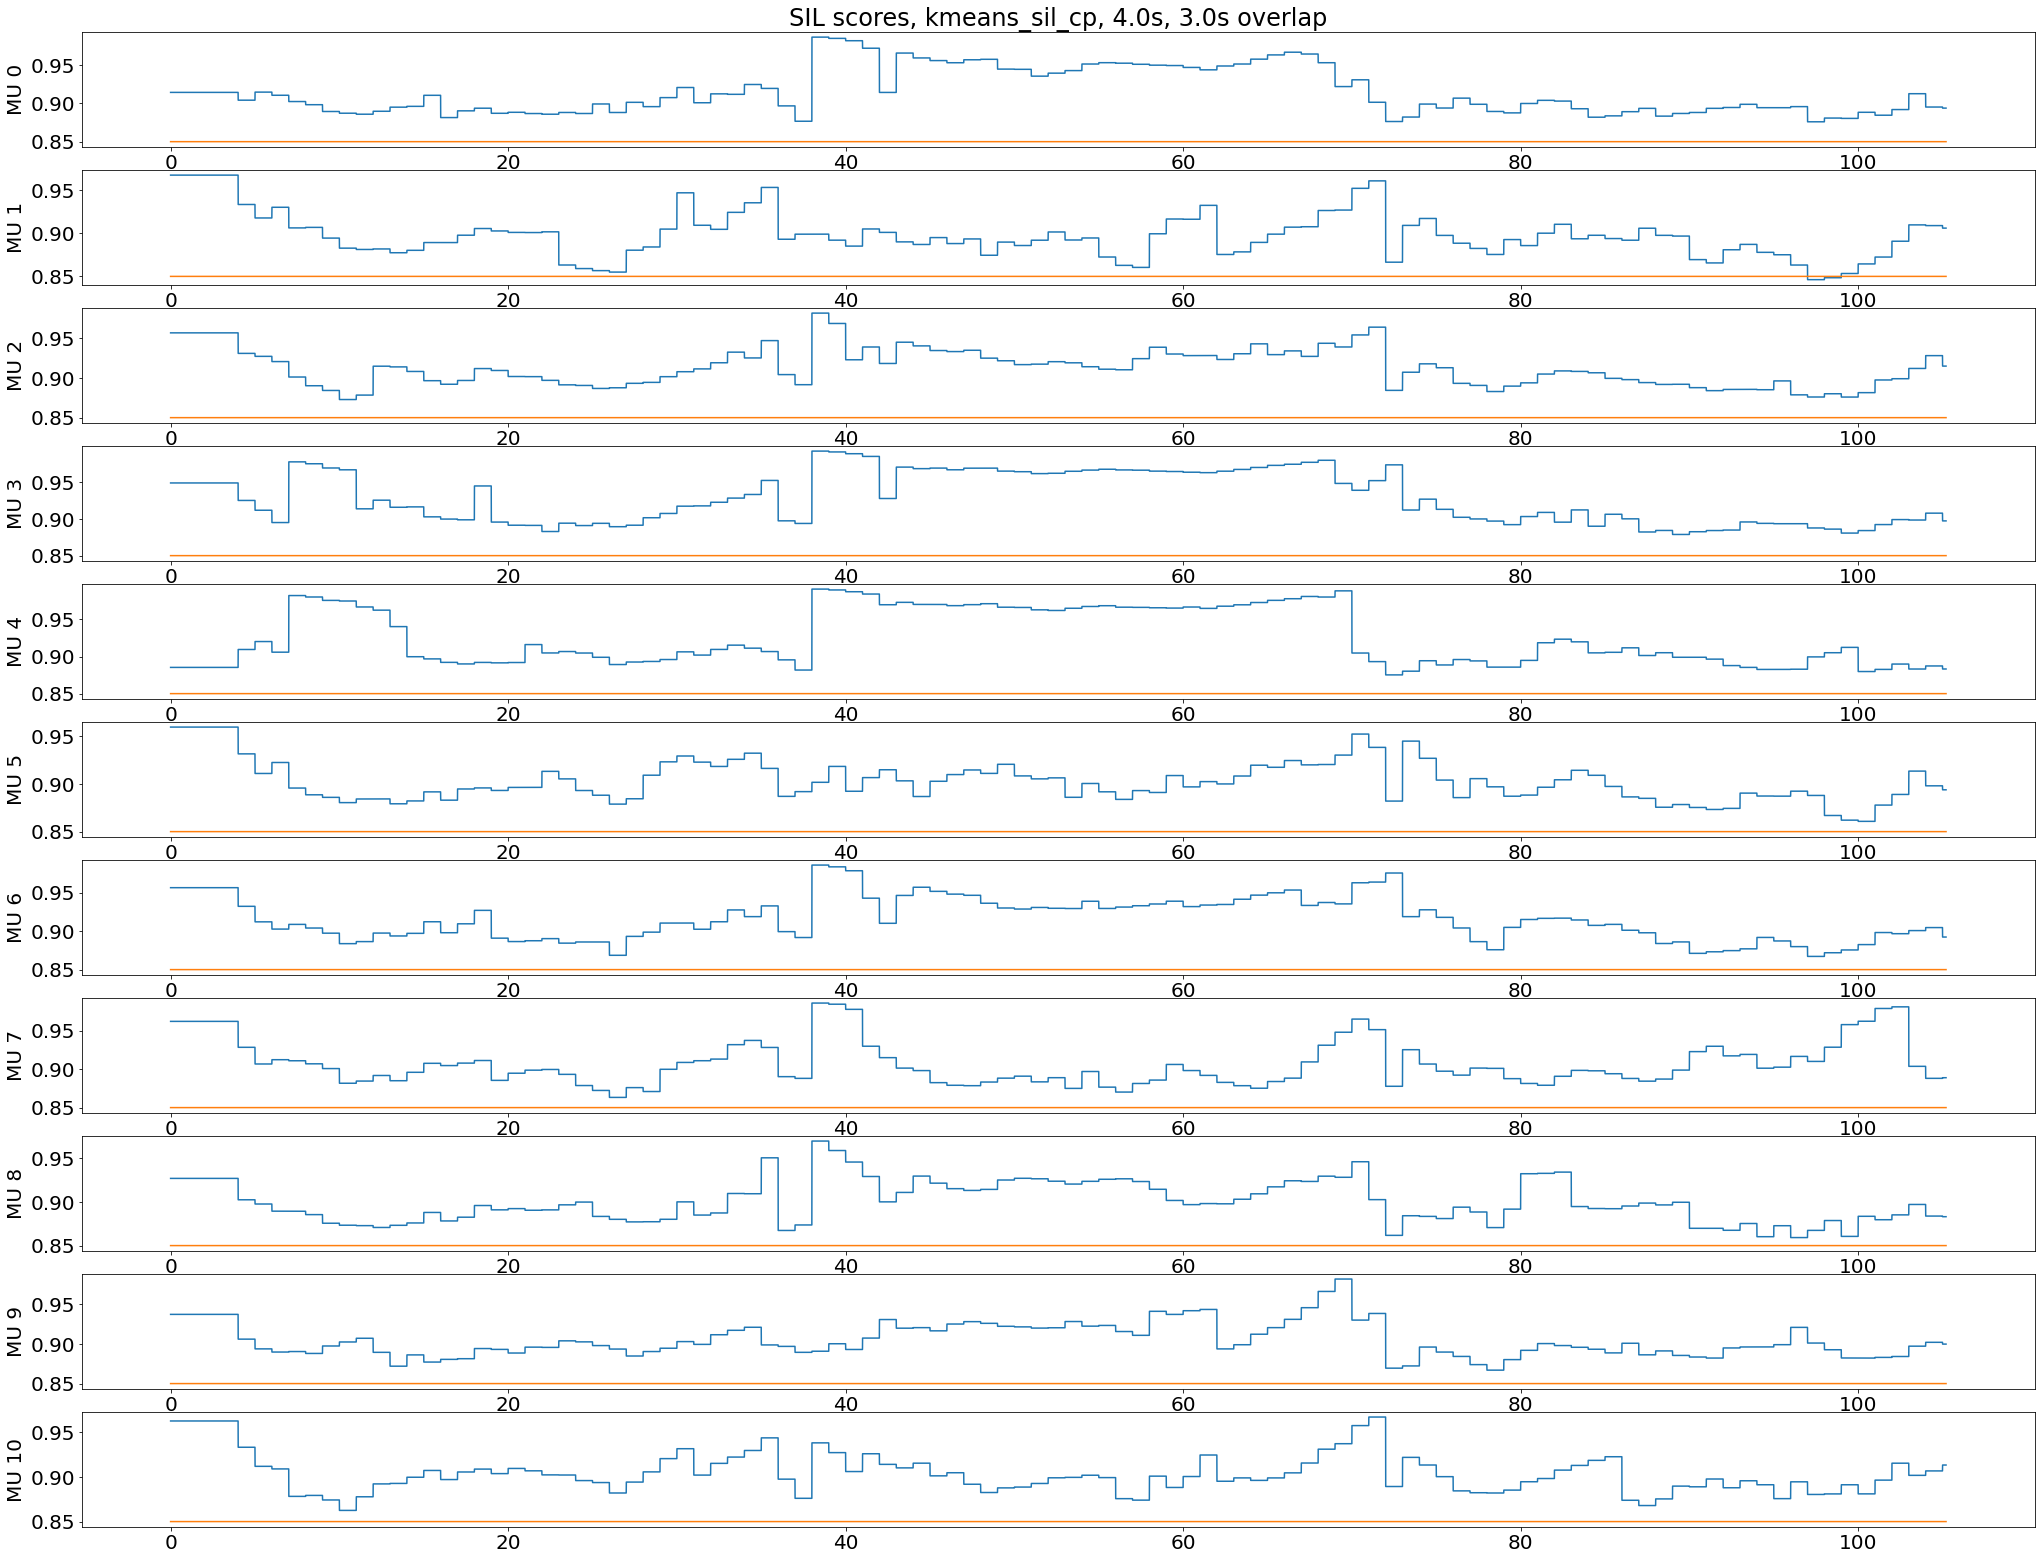

In [19]:
plot_sil(kmeans_sil_cp_40_ol30["sil_scores"], thd_sil=0.85,
         title=f"SIL scores, kmeans_sil_cp, {batch_size}s, {ol[2]}s overlap")

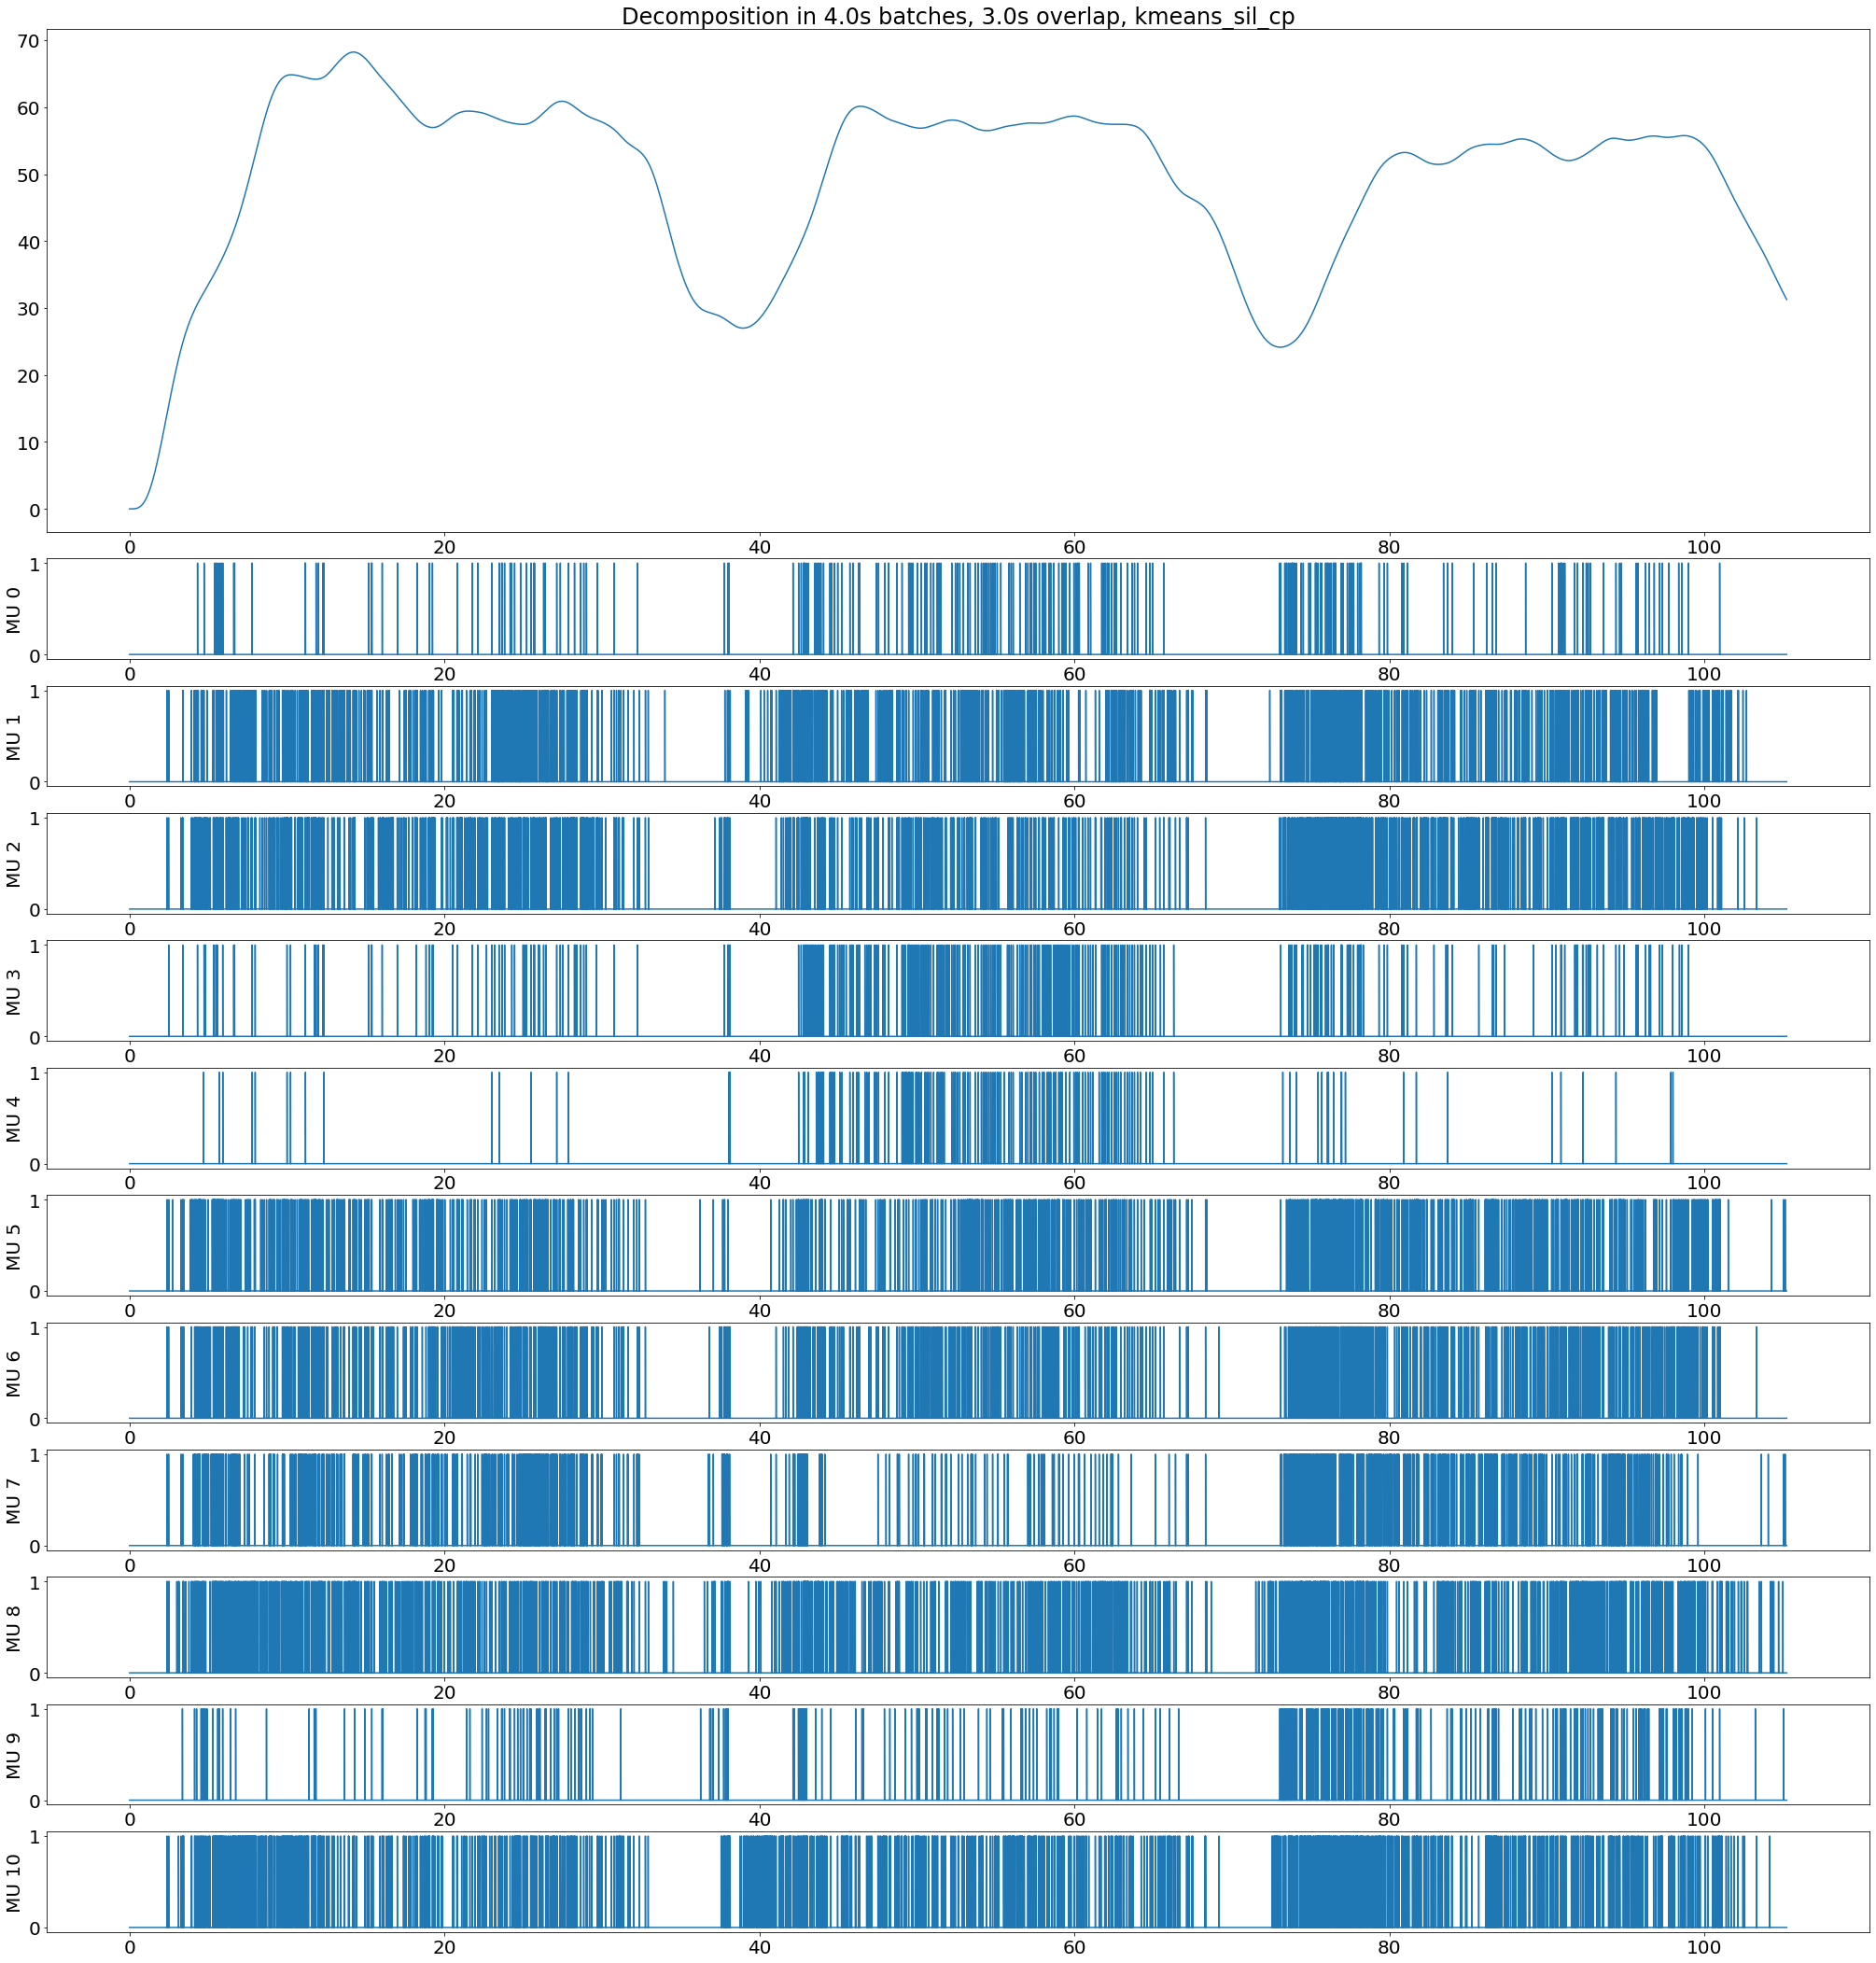

In [20]:
visualize_pt(kmeans_sil_cp_40_ol30["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[2]}s overlap, kmeans_sil_cp")

## ii. `kmeans_cp_sil`
### 4.0s, no overlap

In [21]:
kmeans_cp_sil_40 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                use_kmeans=True, thd_noise=0.38, 
                                classify_mu=False, 
                                sil_dist=True, 
                                thd_sil=0.9, 
                                sc_tm=sc_tm, nc_tm=nc_tm, 
                                batch_size=batch_size, overlap=0.0)

In [22]:
roa_kmeans_cp_sil_40 = calc_roa(ind_pt1=kmeans_cp_sil_40["MUPulses"], 
                                ind_pt2=decomp["MUPulses"], 
                                data=data, 
                                decomp=f"kmeans_cp_sil {batch_size}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s (%):
Motor unit 0: 25.0
Motor unit 1: 2.5726141078838176
Motor unit 2: 9.058295964125561
Motor unit 3: 40.857142857142854
Motor unit 4: 52.54237288135593
Motor unit 5: 5.135658914728682
Motor unit 6: 10.577864838393731
Motor unit 7: 4.878048780487805
Motor unit 8: 6.471030850263356
Motor unit 9: 9.84251968503937
Motor unit 10: 2.4
mean: 15.3941408072201


In [23]:
visualize_pt(kmeans_cp_sil_40["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, kmeans_cp_sil")

### 4.0s, 1.0s overlap

In [24]:
kmeans_cp_sil_40_ol10 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[0])

In [25]:
roa_kmeans_cp_sil_40_ol10 = calc_roa(ind_pt1=kmeans_cp_sil_40_ol10["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_sil {batch_size}s, overlap:{ol[0]}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s, overlap:1.0s (%):
Motor unit 0: 37.5
Motor unit 1: 1.0781671159029649
Motor unit 2: 15.36
Motor unit 3: 55.55555555555556
Motor unit 4: 56.60377358490566
Motor unit 5: 9.45054945054945
Motor unit 6: 22.15447154471545
Motor unit 7: 12.380952380952381
Motor unit 8: 15.99099099099099
Motor unit 9: 13.694267515923567
Motor unit 10: 1.8533440773569703
mean: 21.965642928804815


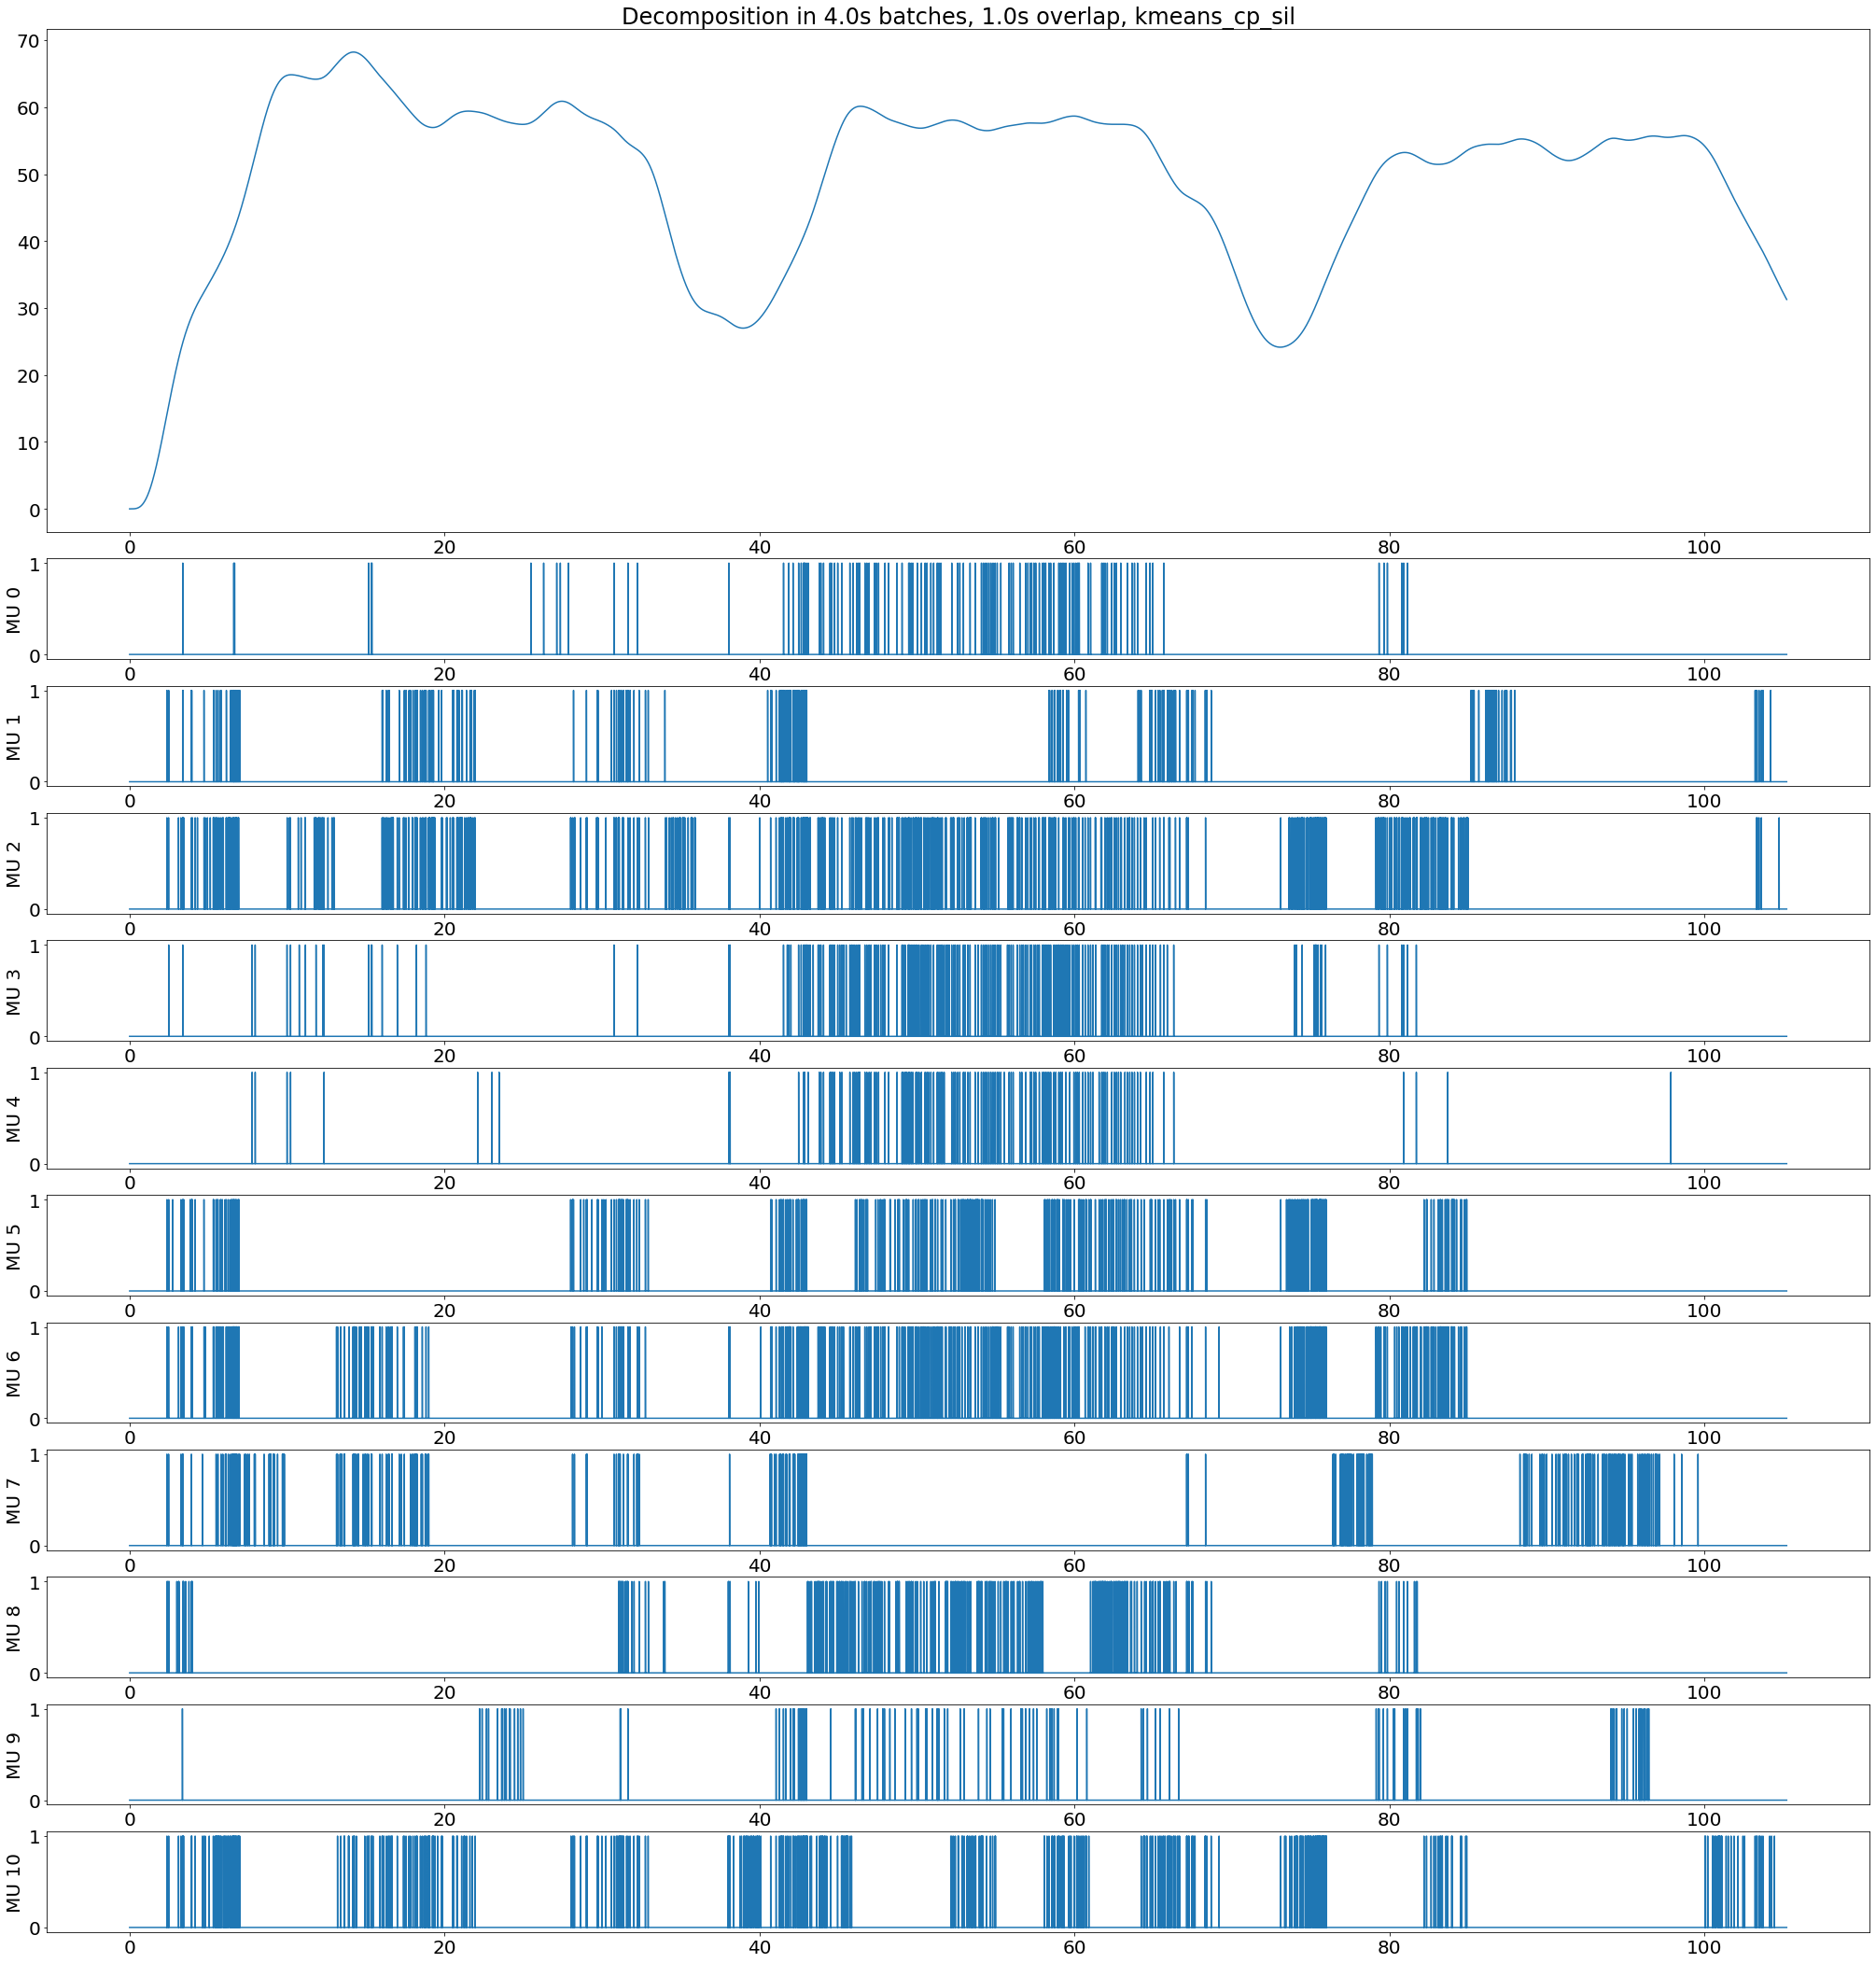

In [26]:
visualize_pt(kmeans_cp_sil_40_ol10["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[0]}s overlap, kmeans_cp_sil")

### 4.0s, 2.0s overlap

In [27]:
kmeans_cp_sil_40_ol20 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[1])

In [28]:
roa_kmeans_cp_sil_40_ol20 = calc_roa(ind_pt1=kmeans_cp_sil_40_ol20["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_sil {batch_size}s, overlap:{ol[1]}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s, overlap:2.0s (%):
Motor unit 0: 36.48068669527897
Motor unit 1: 0.7125890736342043
Motor unit 2: 16.72354948805461
Motor unit 3: 51.851851851851855
Motor unit 4: 57.345971563981045
Motor unit 5: 7.34341252699784
Motor unit 6: 19.814814814814813
Motor unit 7: 11.182108626198083
Motor unit 8: 16.382978723404257
Motor unit 9: 14.982578397212544
Motor unit 10: 1.5767634854771784
mean: 21.308845931536855


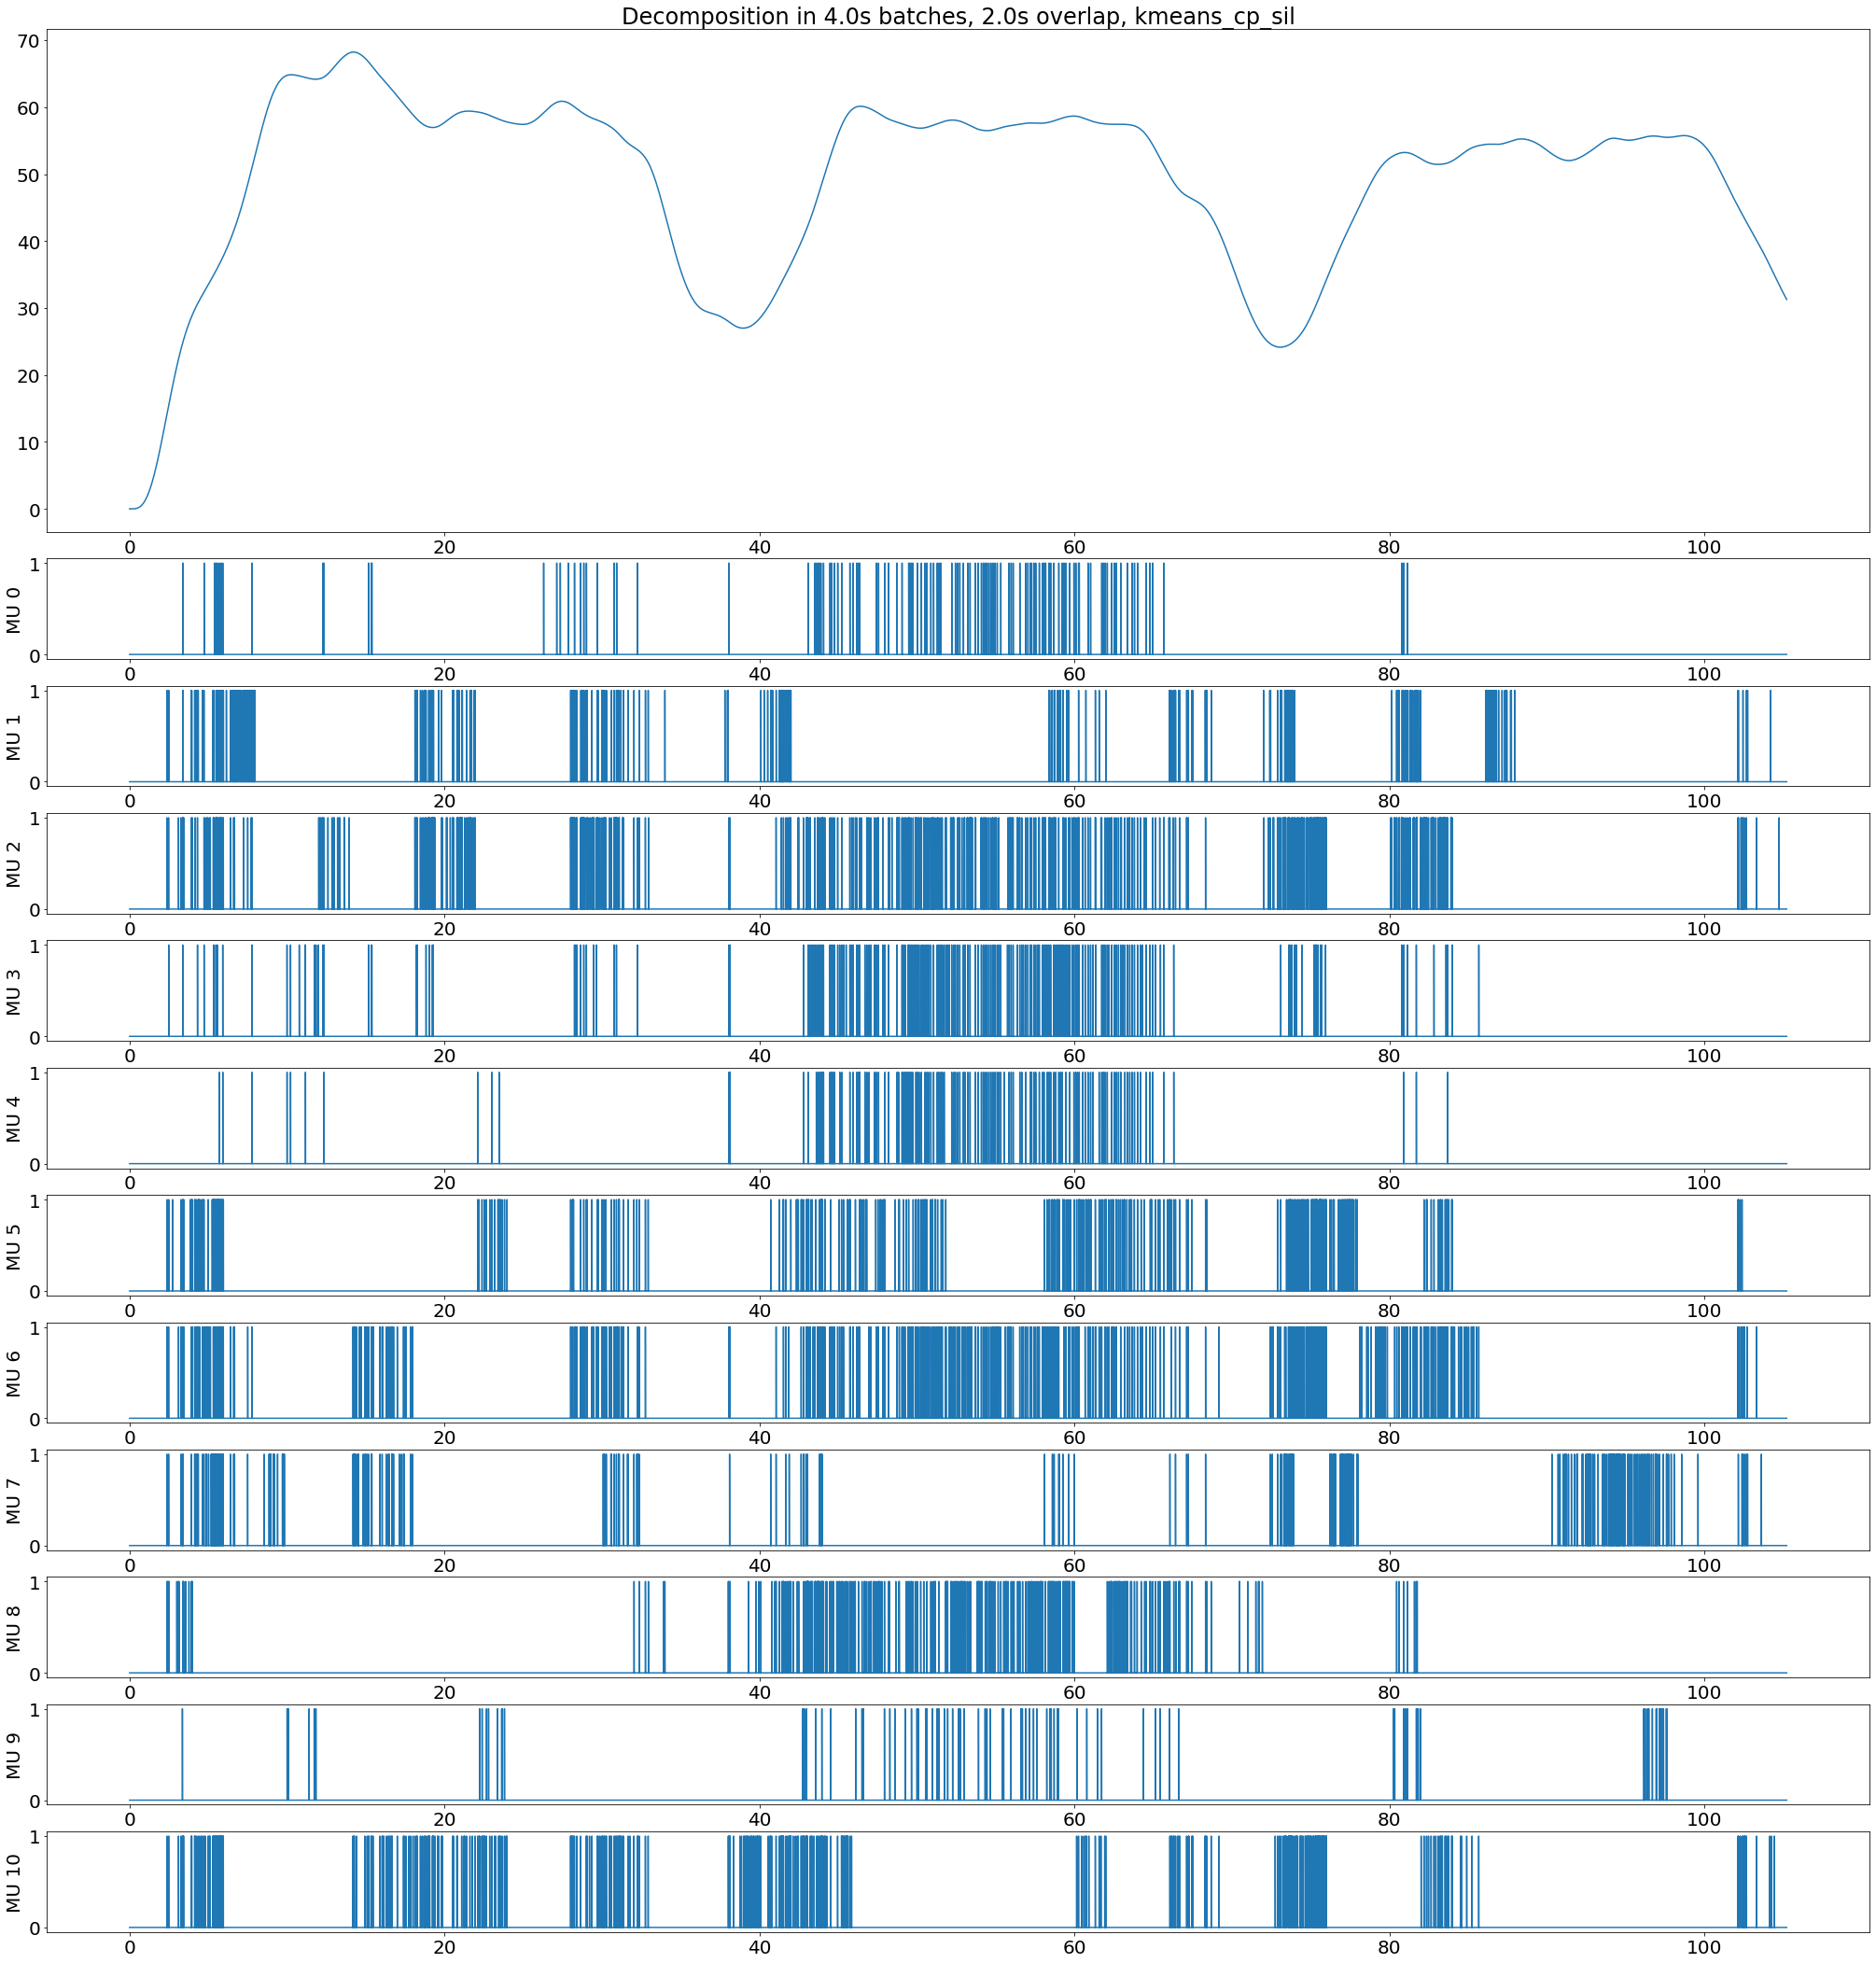

In [29]:
visualize_pt(kmeans_cp_sil_40_ol20["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[1]}s overlap, kmeans_cp_sil")

### 4.0s, 3.0s overlap

In [30]:
kmeans_cp_sil_40_ol30 = batch_decomp2(data, B_rt, mean_tm, discard = bad_ch, 
                                     use_kmeans=True, thd_noise=0.38, 
                                     classify_mu=True, 
                                     sil_dist=True, 
                                     thd_sil=0.9, 
                                     sc_tm=sc_tm, nc_tm=nc_tm, 
                                     batch_size=batch_size, overlap=ol[2])

In [31]:
roa_kmeans_cp_sil_40_ol30 = calc_roa(ind_pt1=kmeans_cp_sil_40_ol30["MUPulses"], 
                                    ind_pt2=decomp["MUPulses"], 
                                    data=data, 
                                    decomp=f"kmeans_cp_sil {batch_size}s, overlap:{ol[2]}s")

RoA between offline decomposition and kmeans_cp_sil 4.0s, overlap:3.0s (%):
Motor unit 0: 35.950413223140494
Motor unit 1: 0.9478672985781991
Motor unit 2: 16.468590831918505
Motor unit 3: 49.82332155477032
Motor unit 4: 57.075471698113205
Motor unit 5: 7.724425887265136
Motor unit 6: 19.89051094890511
Motor unit 7: 10.37463976945245
Motor unit 8: 14.609053497942387
Motor unit 9: 14.191419141914192
Motor unit 10: 1.5285599356395816
mean: 20.780388526149054


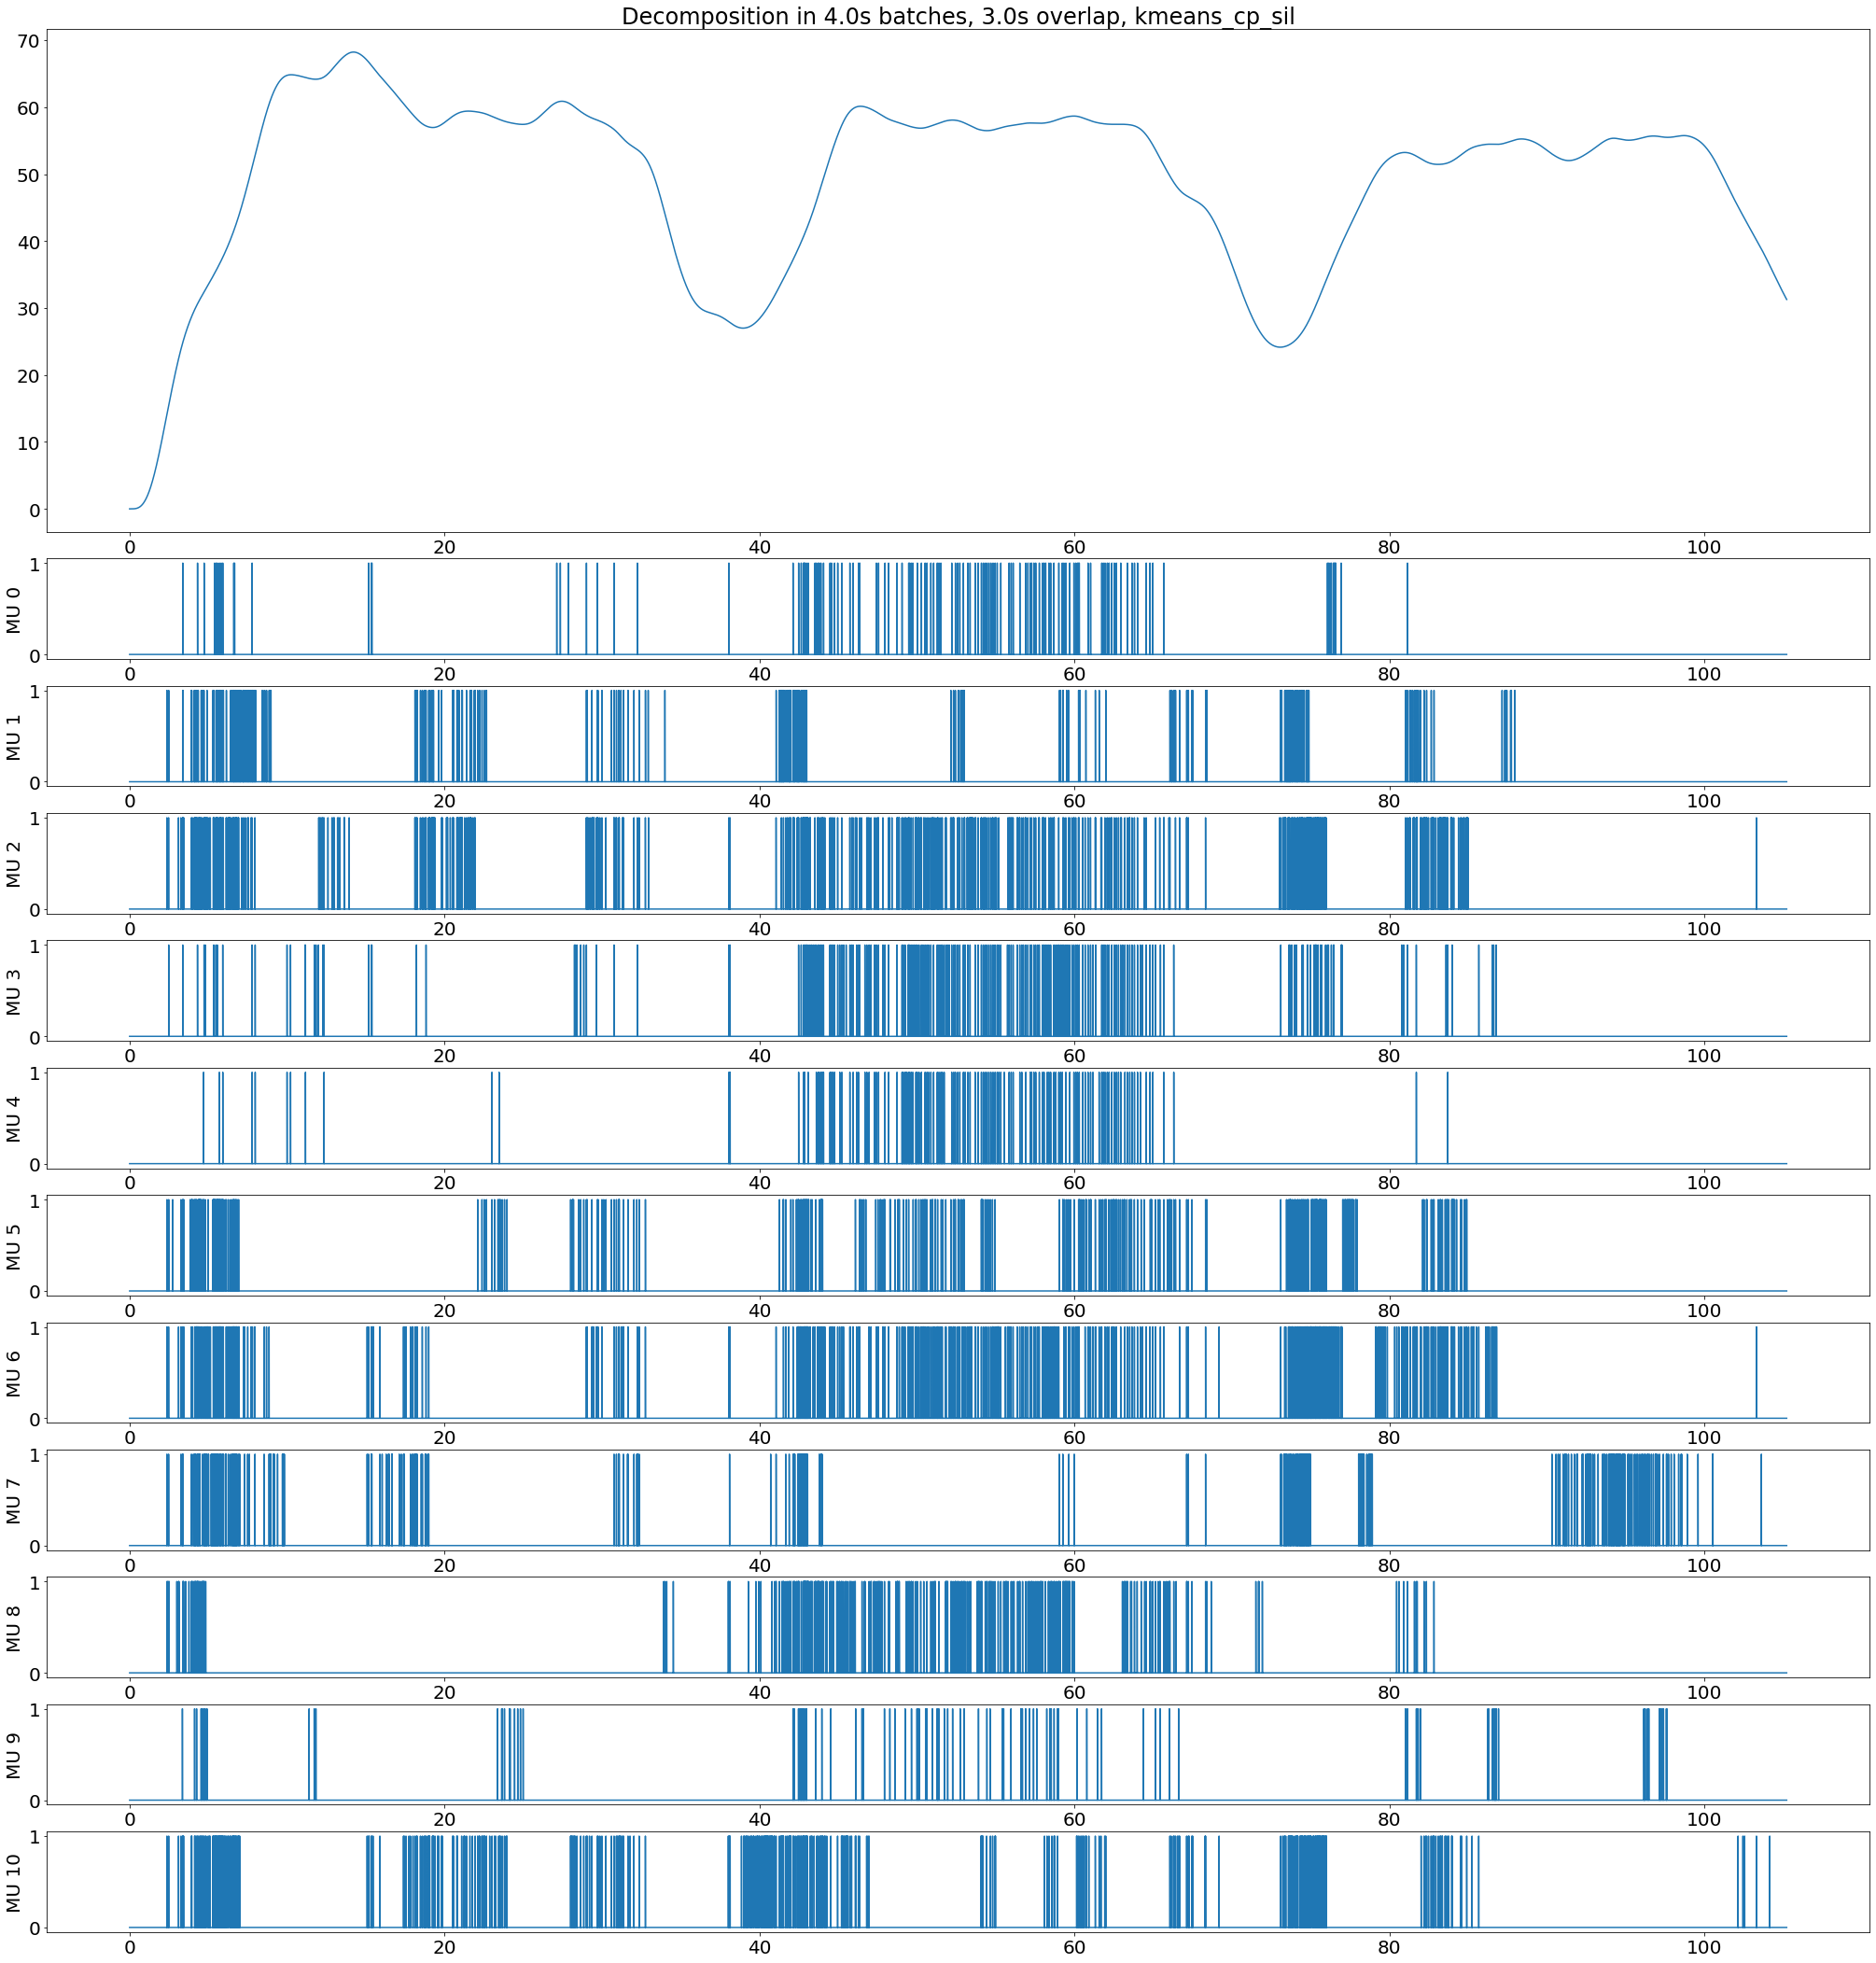

In [32]:
visualize_pt(kmeans_cp_sil_40_ol30["MUPulses"], 
             data, 
             title=f"Decomposition in {batch_size}s batches, {ol[2]}s overlap, kmeans_cp_sil")